In [1]:
from functions import *
from functions_new import *

import numpy as np
import pandas as pd
import os 

import matplotlib.pylab as plt
import matplotlib.patches as patches
from matplotlib.patches import Circle

import seaborn as sns
from seaborn import heatmap
from seaborn import kdeplot

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.signal import savgol_filter

import SOAPify
from SOAPify import SOAPclassification, calculateTransitionMatrix, normalizeMatrixByRow, getSOAPSettings
import SOAPify.HDF5er as HDF5er

from MDAnalysis import Universe as mdaUniverse
from MDAnalysis import transformations
from MDAnalysis.tests.datafiles import TPR, XTC
import MDAnalysis.analysis.msd as msd
from SOAPify.HDF5er import MDA2HDF5
from os import path
import hdbscan
from MDAnalysis.analysis import rdf

from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster

/home/cristina/programs/SOAPify/latest_venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
XYZ_DIR = 'INPUT_files/211_600/'
XYZ_OUTDIR = '211_600/'
NAME = '211_600_every12ps' # NAME.hdf5
GROUP = "/Trajectories/"+NAME
MASK = True #be sure that mask used to create .hdf5 is the same used here

LOAD_HDF5 = True
LOAD_HDF5SOAP = True
LOAD_SOAP = True
LOAD_TimeSOAP = True
LOAD_LENS = True
dt = 1

TRJ_filename = NAME + ".xyz"  # or .lammpsdump 
TOP_filename = topo = NAME + ".data"  # or .data

XYZ_ORIG = [0, 0, 0]
COFF=6  #be sure that is the same coff used to create soaps and lenses
window_length=10
polyorder = 2
wantedTrajectory = slice(0, None, None)
wantedUniverseAtoms = "type Cu"
INIT=0
END=500
STRIDE=1

eq=0

SOAPnmax = 8
SOAPlmax = 8
SOAPatomMask = "Cu"

## Create HDF5 File from TOP and TRJ files

In [3]:
if LOAD_HDF5:
    
    if MASK:
        HDF5_TRJ  = NAME + "mask.hdf5"
        HDF5_TRJ_nomask  = NAME + ".hdf5"
        with h5py.File(XYZ_DIR + HDF5_TRJ, "r") as trajFile:
            tgroup = trajFile[GROUP]
            universe = HDF5er.createUniverseFromSlice(tgroup, wantedTrajectory)
    else:
        HDF5_TRJ  = NAME + ".hdf5"
        HDF5_TRJ_nomask  = NAME + ".hdf5"
        with h5py.File(XYZ_DIR + HDF5_TRJ, "r") as trajFile:
            tgroup = trajFile[GROUP]
            universe = HDF5er.createUniverseFromSlice(tgroup, wantedTrajectory)
    
else:
    mycwd = os.getcwd()
    os.chdir(XYZ_DIR)
    createHDF5(TRJ_filename, TOP_filename, wantedUniverseAtoms)  # Create HDF5 File (if not present)
    os.chdir(mycwd)
    
    if MASK:  # TODO: change HDF5 filename in mask.hdf5
        HDF5_TRJ  = NAME + "mask.hdf5"
        HDF5_TRJ_nomask  = NAME + ".hdf5"
        with h5py.File(XYZ_DIR + HDF5_TRJ, "r") as trajFile:
            tgroup = trajFile[GROUP]
            universe = HDF5er.createUniverseFromSlice(tgroup, wantedTrajectory)
            
    else:
        HDF5_TRJ  = NAME + ".hdf5"
        HDF5_TRJ_nomask  = NAME + ".hdf5"
        with h5py.File(XYZ_DIR + HDF5_TRJ, "r") as trajFile:
            tgroup = trajFile[GROUP]
            universe = HDF5er.createUniverseFromSlice(tgroup, wantedTrajectory)

In [4]:
nAtoms = len(universe.atoms)
windowToUSE = slice(eq+window_length // 2, -(window_length // 2))  # checked for both EVEN and ODD windows
windowToUSE_last = slice(eq+window_length // 2, -(window_length // 2+1))

In [5]:
print(windowToUSE)
print(windowToUSE_last)

slice(5, -5, None)
slice(5, -6, None)


## Create HDF5SOAP File

In [6]:
if LOAD_SOAP:
    pass

else:
    
    mycwd = os.getcwd()
    os.chdir(XYZ_DIR)
    prepareSOAP(HDF5_TRJ_nomask, NAME, COFF, SOAPnmax, SOAPlmax, SOAPatomMask)
    os.chdir(mycwd)

# 1. TimeSOAP

## Read TimeSOAP input

In [7]:
if LOAD_TimeSOAP:
    tsoap = np.load(XYZ_DIR+'time_dSOAP.npz')['name1']
    print(np.shape(tsoap))
else:

    if MASK:
        with h5py.File(XYZ_DIR+NAME+'.hdf5', 'r') as f:
            mask = f[GROUP+"Trajectory"][0, :, 2] > 12
        
        with h5py.File(XYZ_DIR+NAME+'soap.hdf5', 'r') as f:
            ds = f["SOAP/"+NAME]
            fillSettings = getSOAPSettings(ds)
            X = ds[:][:, mask]
        
    else: 
        with h5py.File(XYZ_DIR+NAME+'soap.hdf5', 'r') as f:
            ds = f["SOAP/"+NAME]
            fillSettings = getSOAPSettings(ds)
            X = ds[:, :, :]

    X = SOAPify.fillSOAPVectorFromdscribe(
            X[:], **fillSettings)
        

    X = SOAPify.normalizeArray(X)
    np.savez(XYZ_DIR+'X_normalized.npz', name1=X)
    
    v_soap = np.load(XYZ_DIR+'X_normalized.npz')['name1'][windowToUSE]
    print(np.shape(v_soap))
    
    nAtoms, tSOAP, dtSOAP = getTimeSOAP(XYZ_DIR+NAME+'soap.hdf5', NAME)   

(2000, 995)


In [8]:
nAtoms = np.shape(tsoap)[1]

In [9]:
tsoap_fl = np.array(tsoap).reshape(np.shape(tsoap)[0]*np.shape(tsoap)[1])
np.shape(tsoap_fl)

(1990000,)

## Filtering

In [10]:
tSOAP_rolling = moving_average(np.array(tsoap).T, window_length)
min = np.min(tSOAP_rolling)
print(min)
max = np.max(tSOAP_rolling)
print(max)
tSOAP_rolling_norm = (tSOAP_rolling-min)/(max-min)  # NORMALIZATION
tr_tSOAP_rolling = np.array(tSOAP_rolling_norm).T
fl_tSOAP_rolling = np.reshape(tr_tSOAP_rolling, np.shape(tr_tSOAP_rolling)[0]*np.shape(tr_tSOAP_rolling)[1])

0.005100819307364214
0.08480519999524845


In [11]:
dataToFit = transposeAndFlatten(tSOAP_rolling_norm)
print("minmax: ", np.min(dataToFit), np.max(dataToFit))

minmax:  0.0 1.0


In [12]:
savGolPrint = np.arange(tSOAP_rolling_norm.shape[1])

In [13]:
time = np.arange(savGolPrint[0]+window_length // 2 + 1, savGolPrint[-1]+window_length // 2 + 2 )
xticks = np.array(list(filter(lambda x: (x % 500 == 0), time)))

In [14]:
xticks = [0, 500, 1000, 1500, 2000]

# 2. LENS

# Read LENS input 

In [16]:
if LOAD_LENS:
    LENS = np.load(XYZ_DIR+'lens.npy')
else:
    neigCounts = SOAPify.analysis.listNeighboursAlongTrajectory(universe, cutOff=COFF)
    LENS, nn, *_ = SOAPify.analysis.neighbourChangeInTime(neigCounts)
    np.save(XYZ_DIR+"lens", LENS)

In [17]:
LENS.shape

(995, 2001)

In [18]:
# Remove the first frame (=0.0)
LENS = LENS[:, dt:]

In [19]:
len(LENS[0])

2000

In [20]:
atom = nAtoms - 1

# Filtering

In [21]:
LENS_rolling = moving_average(LENS, window_length)
min = np.min(LENS_rolling)
print(min)
max = np.max(LENS_rolling)
print(max)
LENS_rolling_norm = (LENS_rolling-min)/(max-min)  # NORMALIZATION
tr_LENS_rolling = np.array(LENS_rolling_norm).T
fl_LENS_rolling = np.reshape(tr_LENS_rolling, np.shape(tr_LENS_rolling)[0]*np.shape(tr_LENS_rolling)[1])

0.0
0.3581555636316158


In [22]:
savGolPrint = np.arange(LENS_rolling_norm.shape[1])

In [23]:
LENS_rolling.shape

(995, 1991)

In [24]:
dataToFit = transposeAndFlatten(LENS_rolling_norm)
print("minmax: ", np.min(dataToFit), np.max(dataToFit))

minmax:  0.0 1.0


# 3. (LENS-TimeSOAP) LEAP descriptor

## 3.1 Stack descriptors and reshape

In [33]:
djoint_d = np.dstack((np.transpose(tSOAP_rolling_norm),np.transpose(LENS_rolling_norm)))

In [34]:
np.shape(djoint_d)

(1991, 995, 2)

In [35]:
djoint_d_fl = np.array(djoint_d).reshape(np.shape(djoint_d)[0]*np.shape(djoint_d)[1],np.shape(djoint_d)[2])

In [36]:
djoint_d_fl.shape

(1981045, 2)

In [37]:
LEAP = []

for i in range(0, len(djoint_d_fl)):
    leap = np.sqrt(djoint_d_fl[i, 1]**2+djoint_d_fl[i, 0]**2)
    
    LEAP.append(leap)

In [38]:
ts_LEAP = np.array(LEAP).reshape(LENS_rolling_norm.shape[1], LENS_rolling_norm.shape[0])
ts_LEAP = ts_LEAP.transpose()

## 3.3 2D Onion Clustering

In [39]:
signal_x = []
signal_y = []
clusters_j = []

with open(XYZ_DIR+'signal_with_labels.dat', 'r') as f:
    lines = f.readlines()
    
    for idx, line in enumerate(lines[1:]):
        row = line.split()
        signal_x.append(float(row[0]))
        signal_y.append(float(row[1]))
        clusters_j.append(int(row[2]))

In [40]:
x_dim = len(signal_x)
y_dim = len(signal_y)

In [41]:
signal_joint_fl = np.empty((x_dim, 2))

for i in range(0, x_dim):
    signal_joint_fl[i][0] = signal_x[i]
    signal_joint_fl[i][1] = signal_y[i]    

In [42]:
signal_joint_fl.shape

(1970100, 2)

In [43]:
OnionCL_len = int(signal_joint_fl.shape[0]/djoint_d.shape[1])  #Get the length of data AFTER ONION clustering

In [44]:
OnionCL_len

1980

In [45]:
djoint_dCUT = np.dstack((np.transpose(tSOAP_rolling_norm[:, 0:OnionCL_len]),np.transpose(LENS_rolling_norm[:, 0:OnionCL_len])))

In [46]:
djoint_dCUT.shape

(1980, 995, 2)

In [ ]:
djoint_dCUT_fl = np.array(djoint_dCUT).reshape(np.shape(djoint_dCUT)[0]*np.shape(djoint_dCUT)[1],np.shape(djoint_dCUT)[2])

In [47]:
diffCUT = djoint_d.shape[0] - OnionCL_len
windowToUSE_CUT = slice(eq+window_length // 2, -(window_length // 2+diffCUT))

## 3.5 Get Fluctuations from 1D Onion clusters

In [48]:
# Data from Onion_Clustering/211_600/1D-tsoap/final_states.txt
sigma_lastCL_tSOAP = 0.14
mu_lastCL_tSOAP = 0.45

# Data from Onion_Clustering/211_600/1D-lens/final_states.txt
sigma_lastCL_LENS = 0.2
mu_lastCL_LENS = 0.43

# Data from Onion_Clustering/211_600/1D-lens/final_thresholds.txt
last_thr_tSOAP = 0.5
last_thr_LENS = 0.35

In [49]:
FLUCT_thr_tSOAP = last_thr_tSOAP
FLUCT_thr_LENS = last_thr_LENS

/home/cristina/Desktop/PhD/LEAP/v2.1/functions_new.py:83: RuntimeWarning: divide by zero encountered in log
  lh = numpy.log(h)
/tmp/ipykernel_19289/4123597291.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
/tmp/ipykernel_19289/4123597291.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])


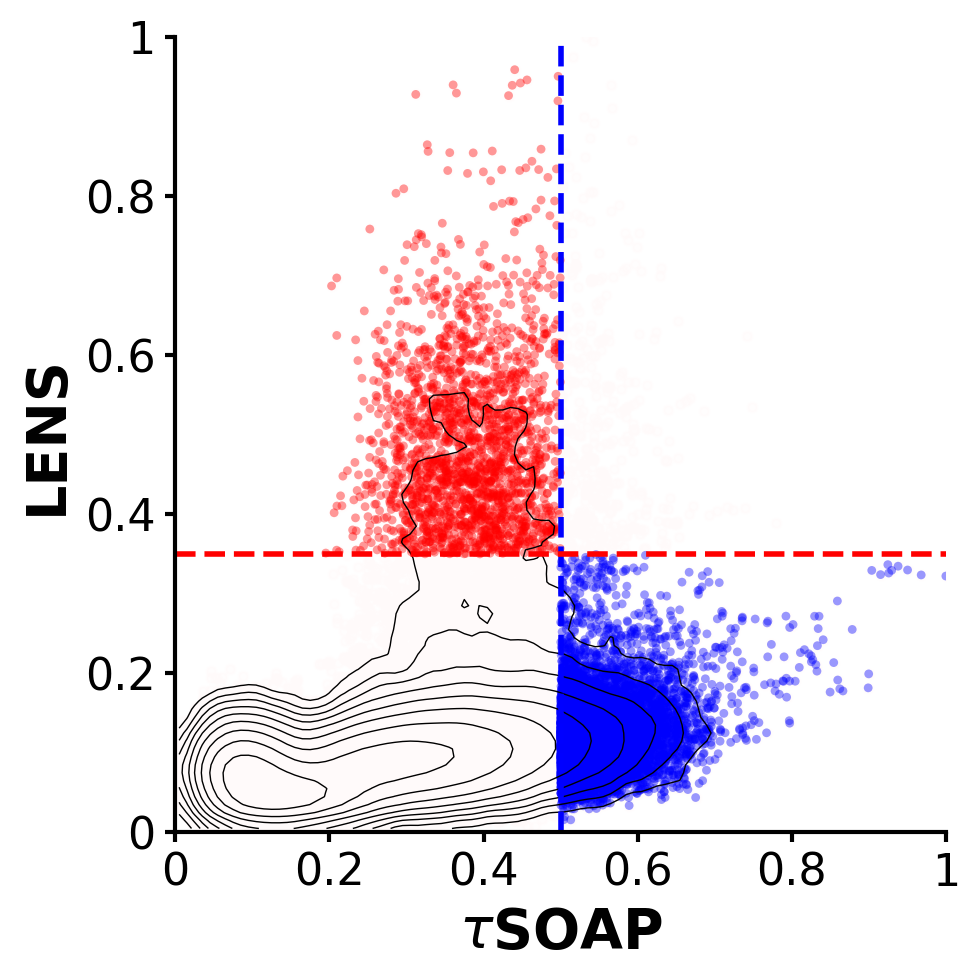

In [50]:
_, ax = plt.subplots(1, figsize=(5,5), dpi=200, tight_layout=True)

ax.scatter(signal_joint_fl[:,0],signal_joint_fl[:,1], c='snow', marker='.', s=40, edgecolors='snow', alpha=0.4)
lh, Xe, Ye, lhmin = getDensity(signal_joint_fl, 0, 1, 100)
levels = 10
cont = ax.contour(Xe,
    Ye,
    lh,
    colors="k",
    linewidths=0.5,
    levels=levels,
    antialiased=True,
    linestyles="solid",
    vmin=lhmin,
    vmax=0,
)

ax.set_xlim((0,1))
ax.set_ylim((0,1))

ax.set_xlabel(r'$\tau$SOAP', weight='bold',size=20)
ax.set_ylabel('LENS', weight='bold',size=20)

ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])

for side in ['right','top']:
    ax.spines[side].set_visible(False)
for side in ['bottom','right','top','left']:
    ax.spines[side].set_linewidth(1.5)
    
    
ax.tick_params(
axis='both',          # changes apply to the x-axis
which='major',      # both major and minor ticks are affected
bottom=True,
left=True,      
labelleft=True,
labelbottom=True,
width=1.5,
labelsize=16,
)     


ax.axvline(x=FLUCT_thr_tSOAP, c="blue", linewidth=2, linestyle="--")
ax.axhline(y=FLUCT_thr_LENS, c="red", linewidth=2, linestyle="--")

tmp = np.where(np.logical_and(signal_joint_fl[:, 0] > FLUCT_thr_tSOAP, signal_joint_fl[:, 1] < 0.35))
ax.scatter(signal_joint_fl[tmp, 0], signal_joint_fl[tmp, 1], c='blue', marker='.', s=40, edgecolors='none', alpha=0.4)

tmp = np.where(np.logical_and(signal_joint_fl[:, 1] > FLUCT_thr_LENS, signal_joint_fl[:, 0] < 0.5))
ax.scatter(signal_joint_fl[tmp, 0], signal_joint_fl[tmp, 1], c='red', marker='.', s=40, edgecolors='none', alpha=0.4)

# tmp = np.where(np.logical_and(signal_joint_fl[:, 1] > 0.35, signal_joint_fl[:, 0] > 0.5))
# ax.scatter(signal_joint_fl[tmp, 0], signal_joint_fl[tmp, 1], c='gray', marker='.', s=40, edgecolors='none', alpha=0.4)

# # draw x and y axis
# ax.arrow(0, 0, 1, 0., fc='k', ec='k', lw = 1.5, 
#          head_width=0.1, head_length=0.1, overhang = 0.1, 
#          length_includes_head= True, clip_on = False) 
 
# ax.arrow(0, 0, 0., 1, fc='k', ec='k', lw = 1.5, 
#          head_width=0.1, head_length=1.5, overhang = 0.5, 
#          length_includes_head= True, clip_on = False) 



# annots = arrowed_spines(ax, locations=('bottom right', 'left up')) 
plt.savefig(XYZ_OUTDIR+'Figure/Onion_clustering_1DBLUE_RED_regions.png')

In [ ]:
# TRJ to draw on to the scatter plot
all_trj = []
for particle in range(0, np.shape(djoint_d)[1]):
    trj = djoint_d[:, particle, :]
    all_trj.append(trj)

## 3.6 Time Correlation Analysis

## Get Confidence intervals to identify tSOAP and LENS fluctuations

In [58]:
data_tSOAP_high = []
for particle in range(0, np.shape(djoint_d)[1]):
    for i in range(0, np.shape(djoint_d)[0]):
        if djoint_d[i, particle, 0] > last_thr_tSOAP:
            data_tSOAP_high.append(djoint_d[i, particle, 0]) 

In [59]:
print(np.mean(data_tSOAP_high))
print(np.std(data_tSOAP_high))

0.5456452392883502
0.04503478079552991


In [60]:
data_LENS_high = []
for particle in range(0, np.shape(djoint_d)[1]):
    for i in range(0, np.shape(djoint_d)[0]):
        if djoint_d[i, particle, 1] > last_thr_LENS:
            data_LENS_high.append(djoint_d[i, particle, 1]) 

In [61]:
print(np.mean(data_LENS_high))
print(np.std(data_LENS_high))

0.4932501588365938
0.11177337004445055


In [62]:
Sup_thr_tSOAP = np.mean(data_tSOAP_high) - np.std(data_tSOAP_high)
Sup_thr_LENS = np.mean(data_LENS_high) - np.std(data_LENS_high)

In [63]:
Sup_thr_tSOAP

0.5006104584928203

In [64]:
Sup_thr_LENS

0.38147678879214325

In [65]:
Inf_thr_tSOAP = np.mean(data_tSOAP_high) - 2*np.std(data_tSOAP_high)
Inf_thr_LENS = np.mean(data_LENS_high) - 2*np.std(data_LENS_high)

In [66]:
Inf_thr_tSOAP 

0.45557567769729035

In [67]:
Inf_thr_LENS

0.26970341874769266

## Get particles passing through RED and BLUE regions

In [68]:
# PARTICLES going in the BLUE region
count_hightsoap = 0

for particle in range(0, np.shape(djoint_d)[1]):
    for i in range(0, np.shape(djoint_d)[0]):
        if djoint_d[i, particle, 0] > Sup_thr_tSOAP and djoint_d[i, particle, 1] < Inf_thr_LENS:
            count_hightsoap = count_hightsoap + 1
            break
            
perc_hightsoap = count_hightsoap/np.shape(djoint_d)[1]*100

In [69]:
perc_hightsoap

22.512562814070353

In [70]:
# PARTICLES going in the RED region
count_highlens = 0

for particle in range(0, np.shape(djoint_d)[1]):
    for i in range(0, np.shape(djoint_d)[0]):
        if djoint_d[i, particle, 1] > Sup_thr_LENS and djoint_d[i, particle, 0] < Inf_thr_tSOAP:
            count_highlens = count_highlens + 1
            break
            
perc_highlens = count_highlens/np.shape(djoint_d)[1]*100

In [71]:
perc_highlens

1.809045226130653

In [72]:
# FROM tsoap TO LENS
HtsoapTOHlens = 0 
delay_Htsoap_Hlens = []


for particle in range(0, np.shape(djoint_d)[1]):
    hightsoap = False
    for i in range(0, np.shape(djoint_d)[0]):
        if djoint_d[i, particle, 0] > Sup_thr_tSOAP and djoint_d[i, particle, 1] < Inf_thr_LENS:
            hightsoap = True
            ts_Htsoap = i
        if djoint_d[i, particle, 1] > Sup_thr_LENS and djoint_d[i, particle, 0] < Inf_thr_tSOAP and hightsoap == True:
            HtsoapTOHlens = HtsoapTOHlens + 1
            ts_Hlens = i
            delay_Htsoap_Hlens.append(ts_Hlens - ts_Htsoap)
            break

In [73]:
HtsoapTOHlens

18

In [74]:
perc_HlensFROMHtsoap = HtsoapTOHlens/count_hightsoap*100

In [75]:
perc_HlensFROMHtsoap

8.035714285714286

In [76]:
#perc_HlensFROMHtsoap_rel = HtsoapTOHlens/count_highlens*100

In [77]:
#perc_HlensFROMHtsoap_rel

In [78]:
len(delay_Htsoap_Hlens)

18

In [79]:
# FROM LENS TO tSOAP
HlensTOHtsoap = 0 
delay_Hlens_Htsoap = []

for particle in range(0, np.shape(djoint_d)[1]):
    highlens = False
    for i in range(0, np.shape(djoint_d)[0]):
        if djoint_d[i, particle, 1] > Sup_thr_LENS and djoint_d[i, particle, 0] < Inf_thr_tSOAP:
            highlens = True
            ts_Hlens = i
        if djoint_d[i, particle, 0] > Sup_thr_tSOAP and djoint_d[i, particle, 1] < Inf_thr_LENS and highlens == True:
            HlensTOHtsoap = HlensTOHtsoap + 1
            ts_Htsoap = i
            delay_Hlens_Htsoap.append(ts_Htsoap - ts_Hlens)
            break

In [80]:
HlensTOHtsoap

16

In [81]:
perc_HtsoapFROMHlens = HlensTOHtsoap/count_highlens*100

In [82]:
perc_HtsoapFROMHlens

88.88888888888889

In [83]:
delay_Hlens_Htsoap

[8, 130, 5, 23, 15, 11, 9, 11, 56, 9, 29, 5, 47, 43, 6, 94]

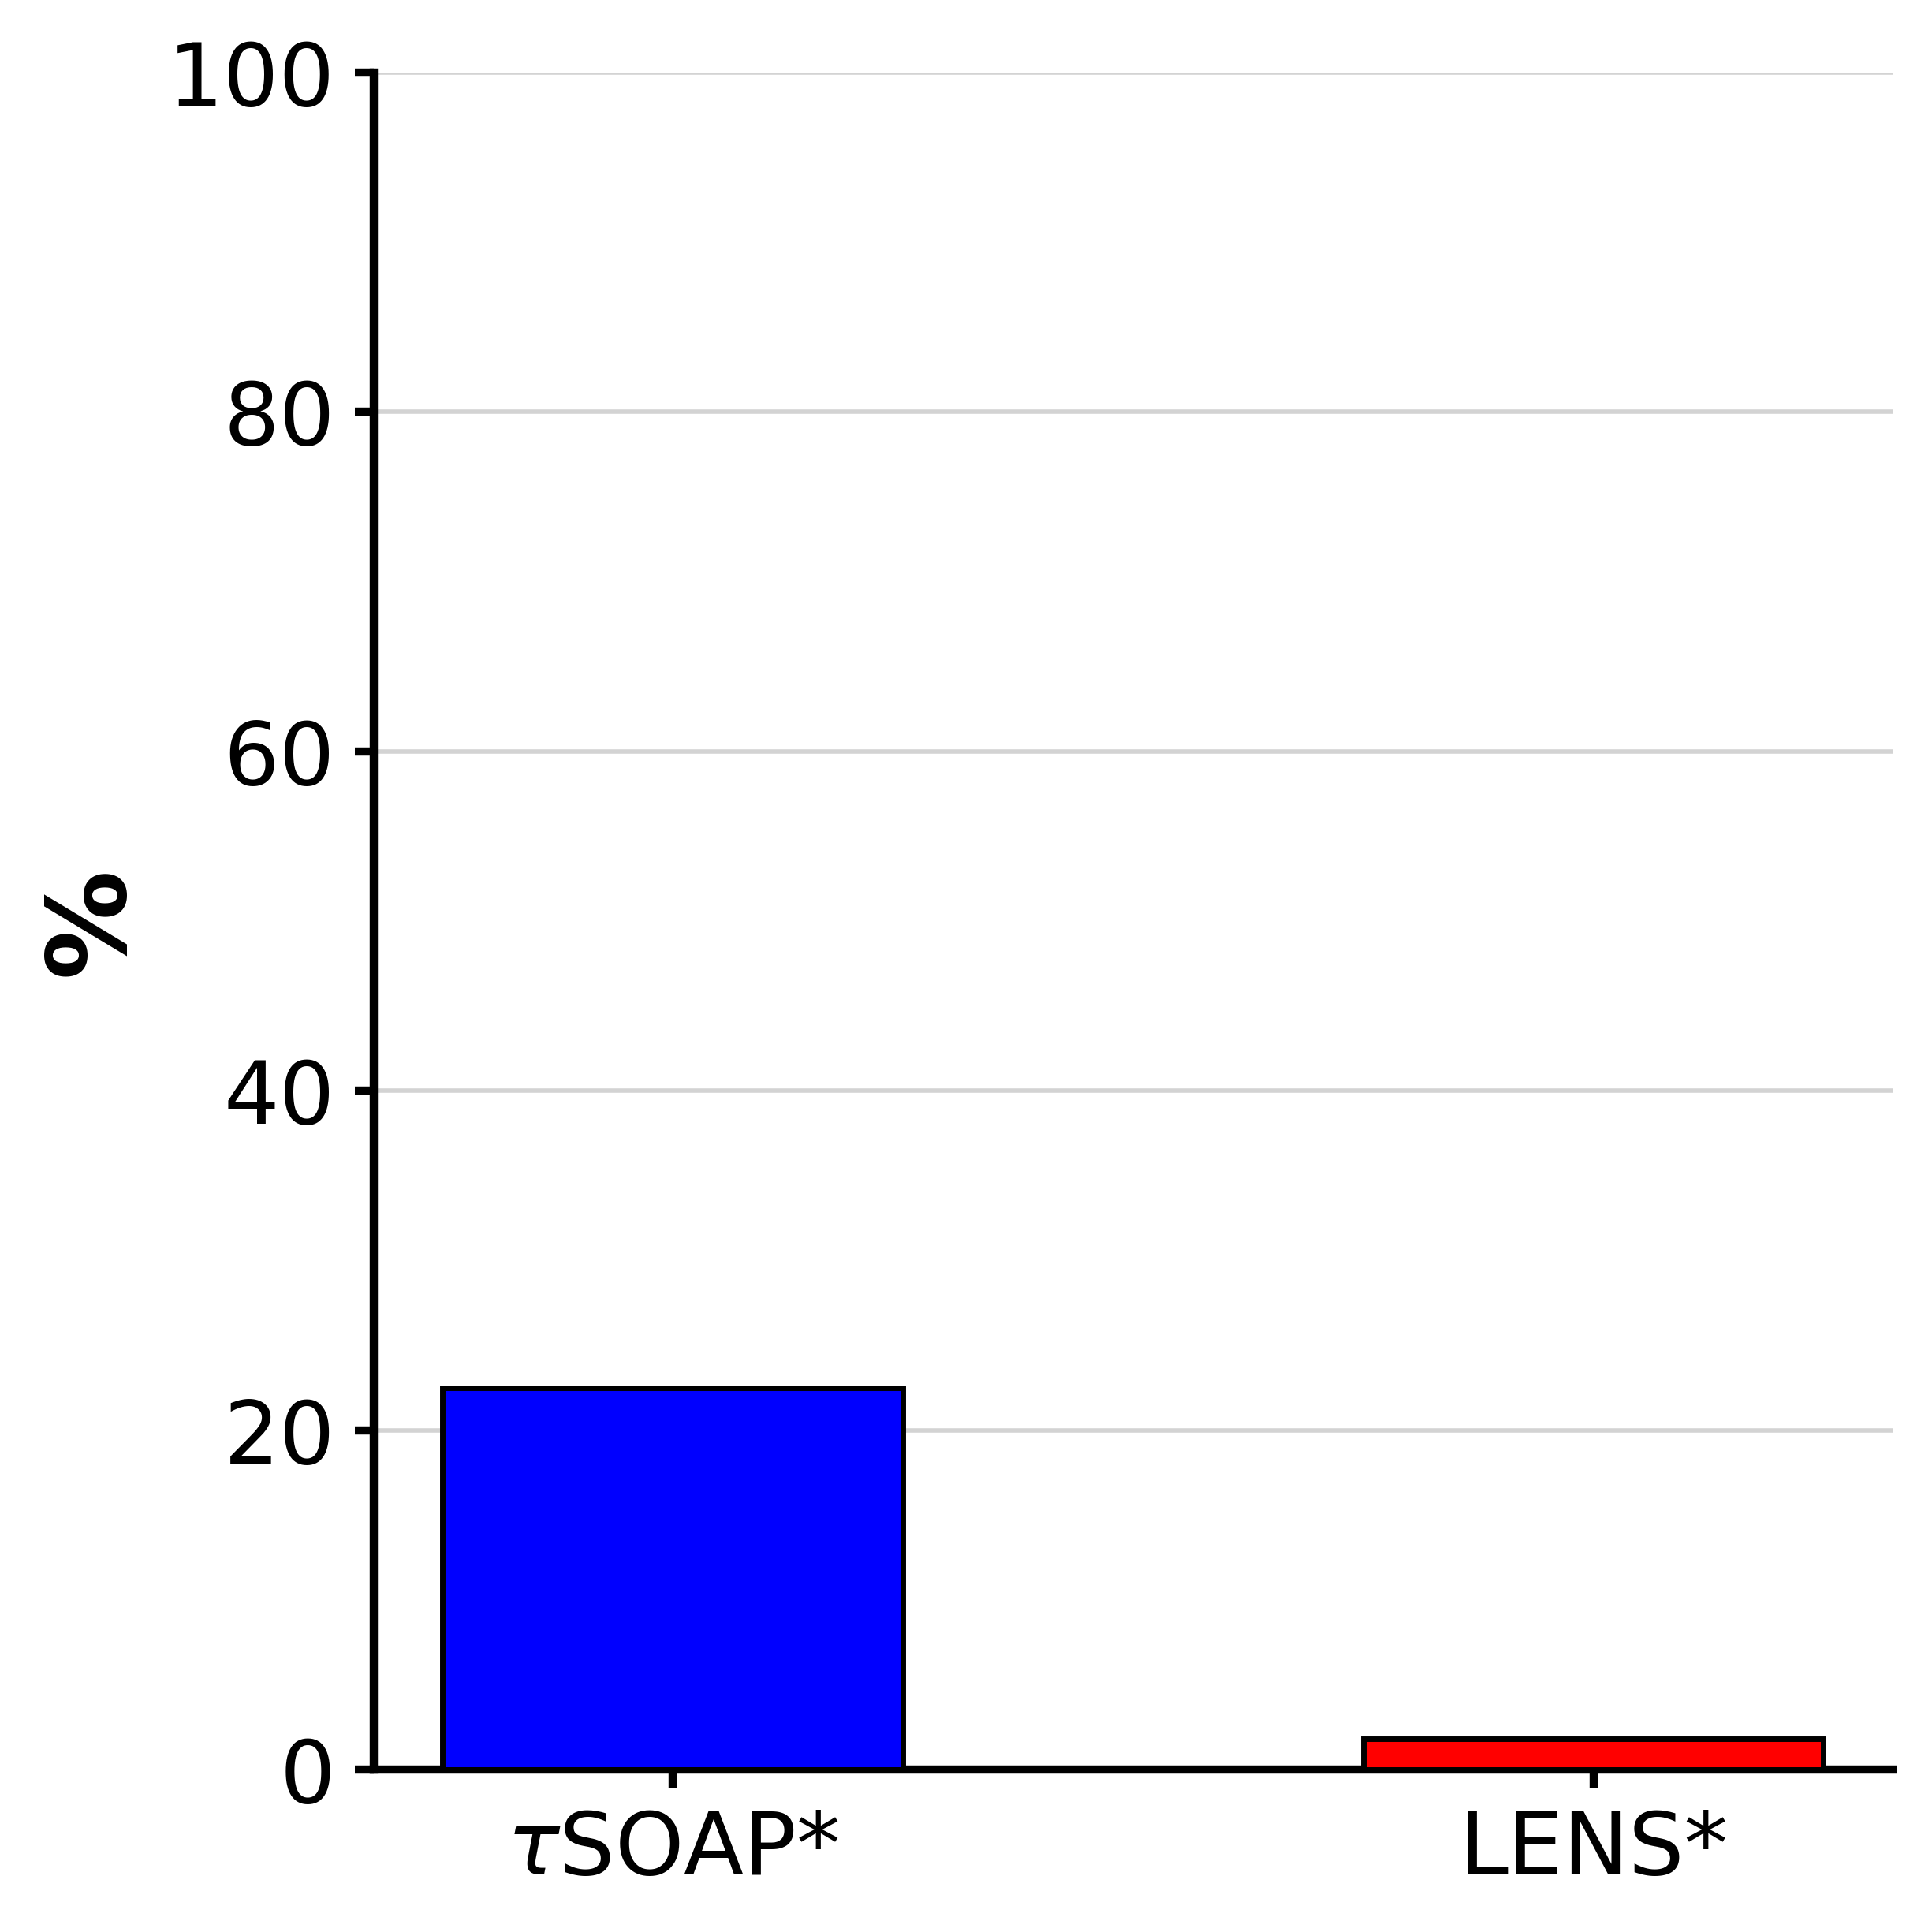

In [84]:
# PLOT

groups = [r'$\tau$SOAP*', 'LENS*']
values1 = [perc_hightsoap, 0]
values2 = [0, perc_highlens]
# values3 = [0, 0, perc_linearity]

width = 0.5
fig, ax = plt.subplots(figsize =(5, 5), dpi=500, tight_layout=True)

# ax.bar(groups, values3, color = "snow", ec = "black", lw = .75, zorder = 3, 
#     width = width)
ax.bar(groups, values1, color = "blue", ec = "black", lw = 1, zorder = 3, 
    width = width, label = r'$\tau$SOAP*')
ax.bar(groups, values2, color = "red", ec = "black", lw = 1, zorder = 3, 
    width = width, label = r'LENS*')
# ax.bar(groups, values3, color = "gray", ec = "black", lw = 1, zorder = 3, 
#     width = width, label = r'Linearity')

xticks_ = ax.xaxis.set_ticks(
    ticks = groups,
    labels = groups,
    fontsize=20
)
yticks_ = ax.yaxis.set_ticks(
    ticks = np.arange(0, 101, 20),
    labels = [0, 20, 40, 60, 80, 100],
    fontsize=20)

ax.set_ylabel('%', weight='bold', size=20)

ax.spines["top"].set(visible = False)
ax.spines["right"].set(visible = False)

ax.set_axisbelow(True)
ax.yaxis.grid(True, color='lightgray')
ax.xaxis.grid(False)

for side in ['bottom','right','top','left']:
    ax.spines[side].set_linewidth(1.5)
# We specify the width of the bar

ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=True,
    left=True,      
    labelleft=True,
    labelbottom=True,
    width=1.5,
    labelsize=16,
) 

plt.savefig(XYZ_OUTDIR+'Figure/tsoap_LENS_perc.png', bbox_inches='tight')

In [85]:
delay_Hlens_Htsoap

[8, 130, 5, 23, 15, 11, 9, 11, 56, 9, 29, 5, 47, 43, 6, 94]

In [86]:
delay_Htsoap_Hlens

[8, 207, 95, 184, 10, 8, 10, 11, 194, 119, 21, 43, 168, 98, 7, 106, 194, 39]

In [87]:
xticks = [0, 16.667, 33.333, 50, 66.666, 83.333]

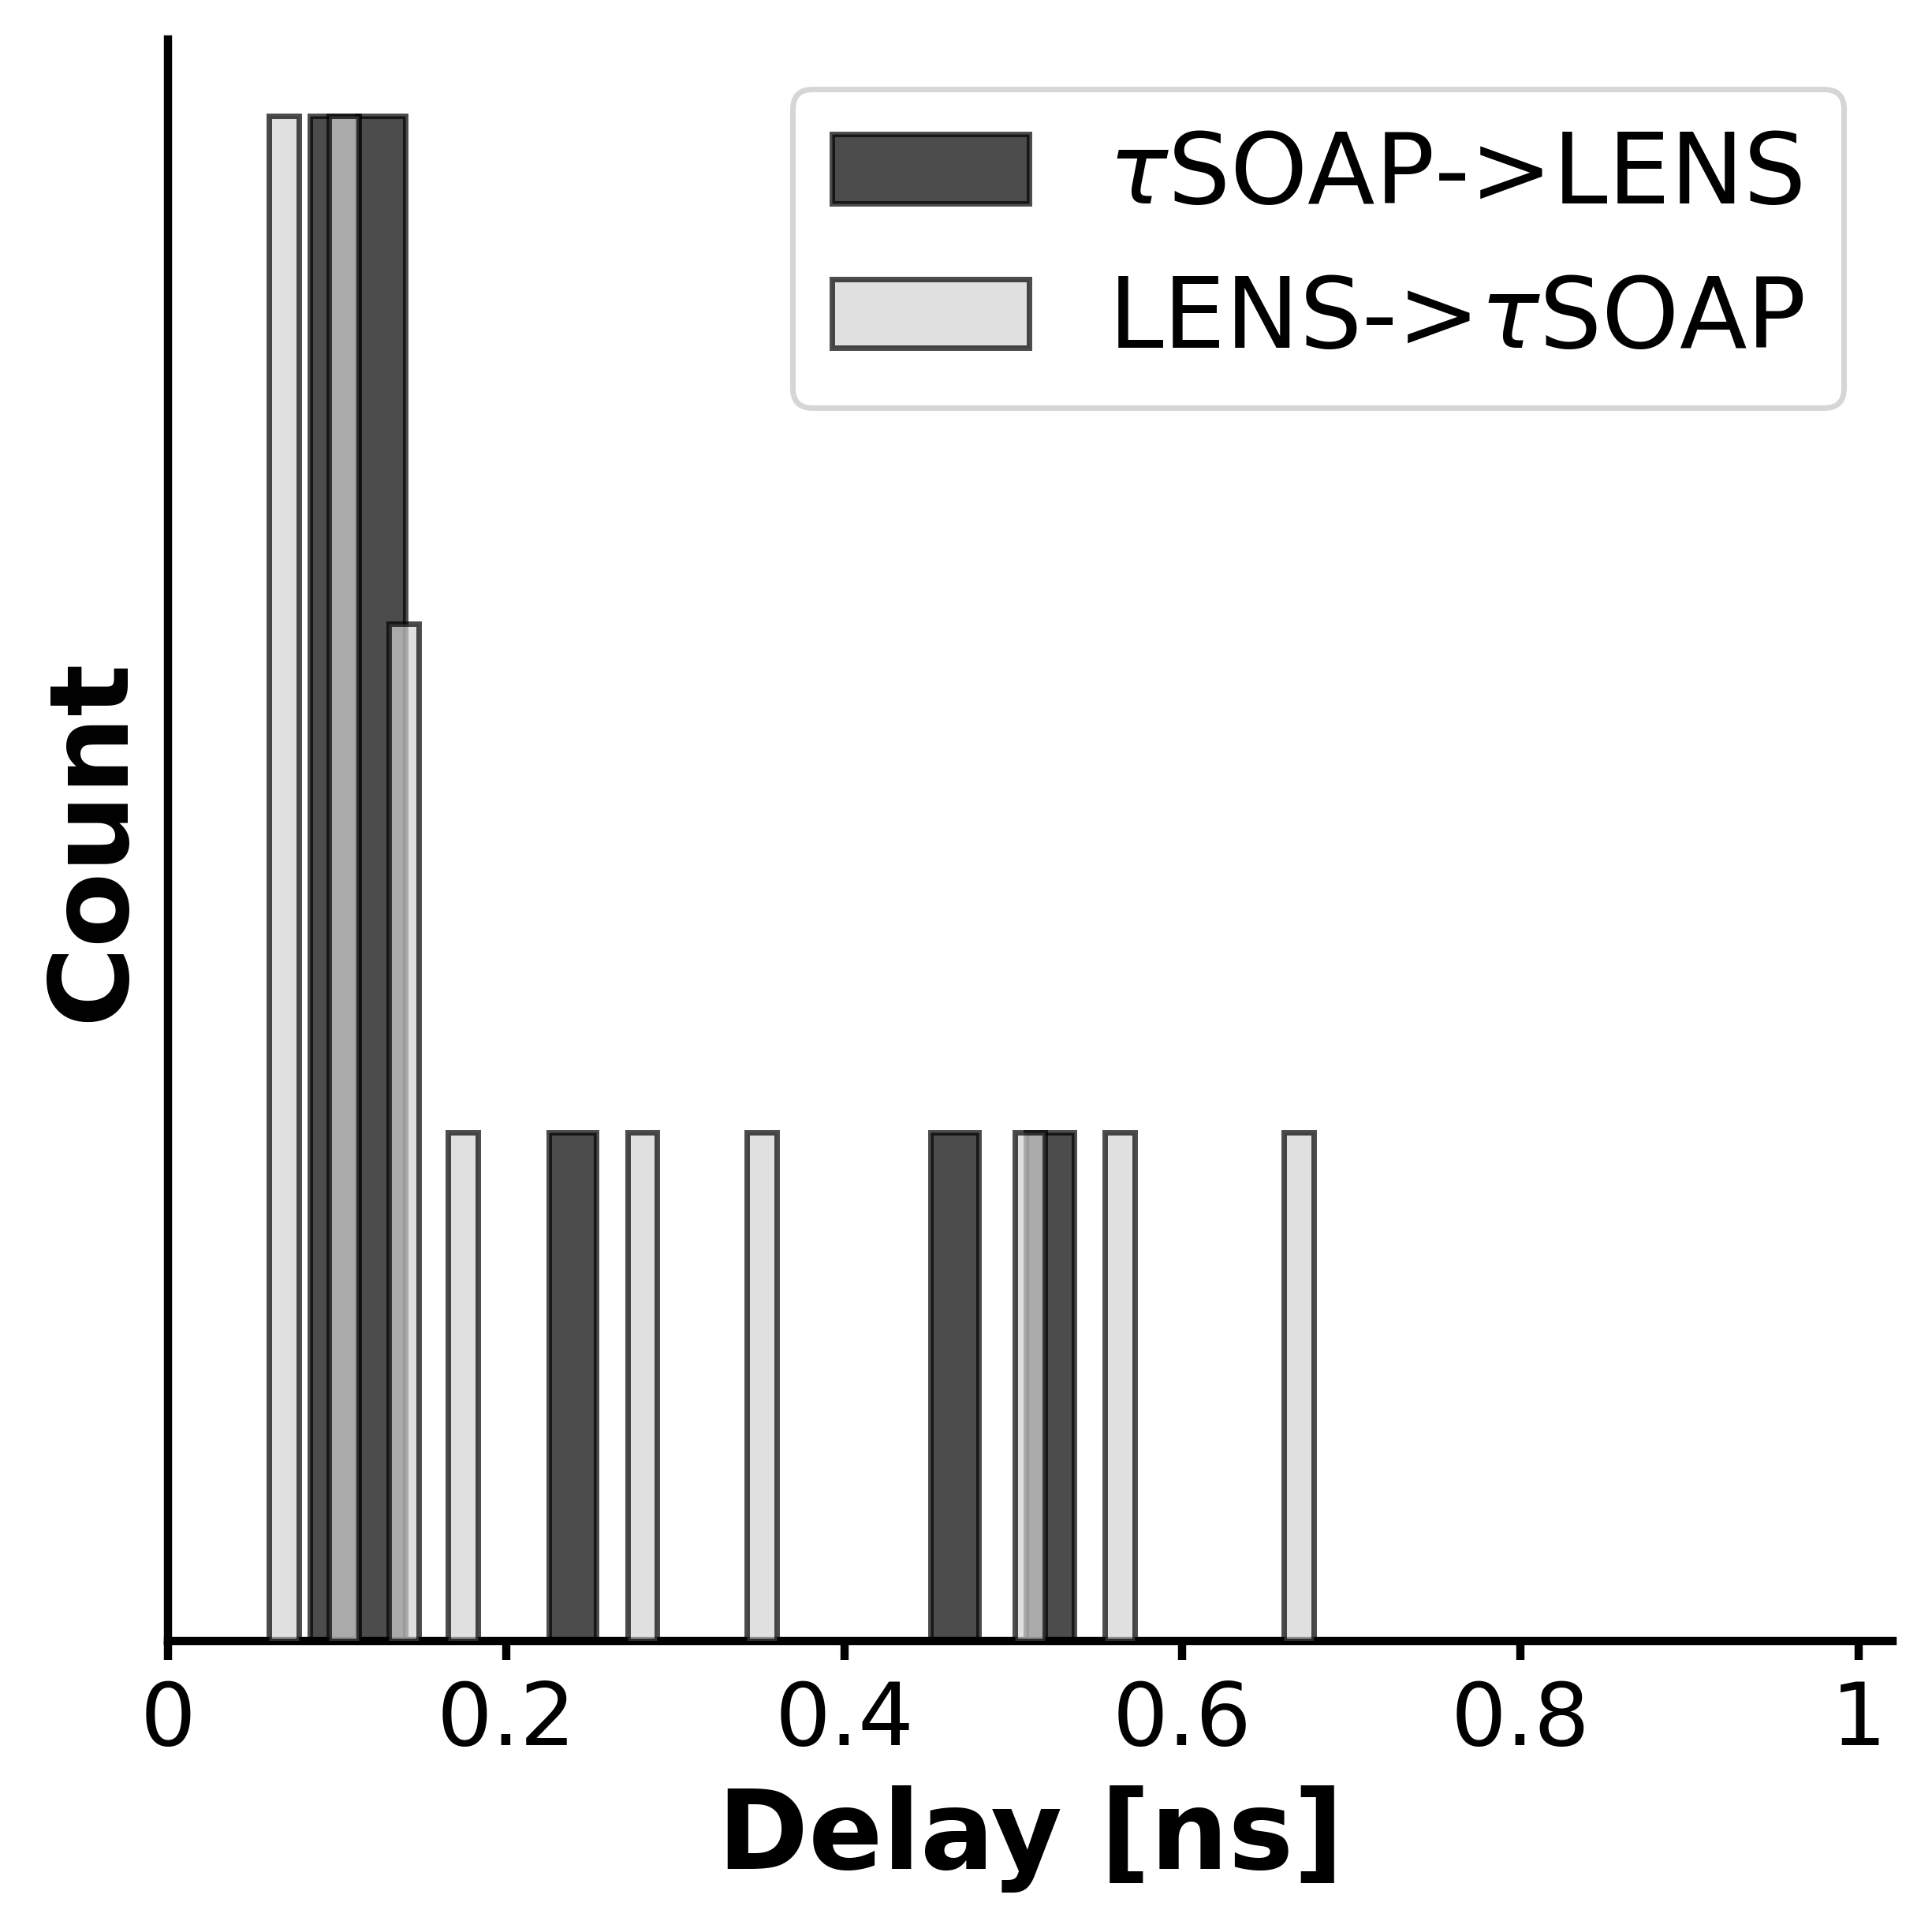

In [88]:
fig, ax = plt.subplots(1, figsize=(5,5), dpi=500, tight_layout=True)
# sns.kdeplot(data=delay_Htsoap_Hlens, color='silver', bw_adjust=0.4, linewidth=2, fill=False, label=r'$\tau$SOAP->LENS')
# sns.kdeplot(data=delay_Hlens_Htsoap, color='darkslategray', bw_adjust=0.4, linewidth=2, fill=False, label=r'LENS->$\tau$SOAP')

plt.hist(x=delay_Htsoap_Hlens, color='black',
                            alpha=0.7, ec = "black", lw = 1, bins=85, zorder = 3, rwidth=1, label=r'$\tau$SOAP->LENS')

plt.hist(x=delay_Hlens_Htsoap, color='lightgray',
                            alpha=0.7, ec = "black", lw = 1, bins=85, zorder = 3, rwidth=1, label=r'LENS->$\tau$SOAP')
ax.set_xlim(0, 85)
# ax.set_ylim(0, 4)
ax.set_xlabel('Delay [ns]', weight='bold', size=20)
ax.set_xticks(xticks)
ax.set_xticklabels([0, np.round(float(16.667*0.012), decimals=1), np.round(float(33.333*0.012), decimals=1), np.round(float(50*0.012), decimals=1), np.round(float(66.666*0.012), decimals=1), 1], size=16)
ax.set_ylabel('Count', weight='bold', size=20)
ax.set_yticks([])

for side in ['right','top']:
    ax.spines[side].set_visible(False)
for side in ['bottom','right','top','left']:
    ax.spines[side].set_linewidth(1.5)
    
ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=True,
    left=True,      
    labelleft=True,
    labelbottom=True,
    width=1.5,
    labelsize=16,
) 


plt.legend(fontsize=18)
plt.savefig(XYZ_OUTDIR+'Figure/delay.png', bbox_inches='tight')

/tmp/ipykernel_19289/3937220040.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
/tmp/ipykernel_19289/3937220040.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])


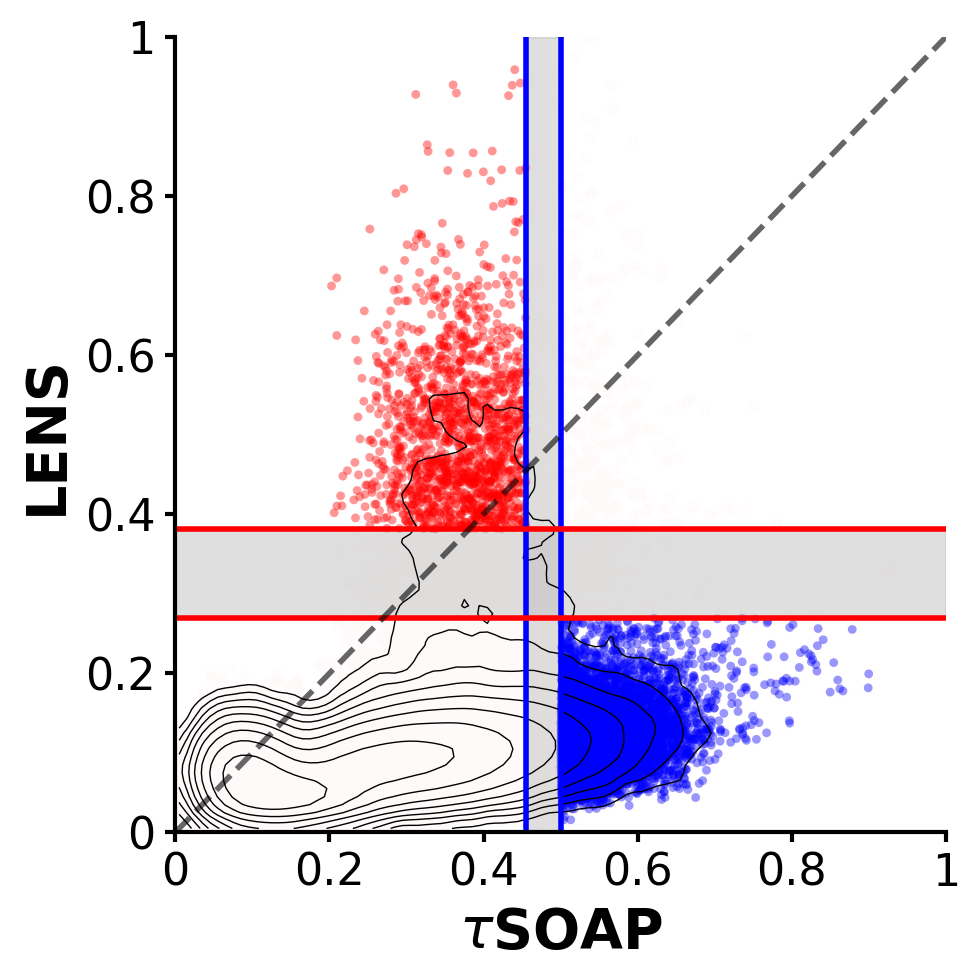

In [89]:
_, ax = plt.subplots(1, figsize=(5,5), dpi=200, tight_layout=True)

ax.scatter(signal_joint_fl[:,0],signal_joint_fl[:,1], c='snow', marker='.', s=40, edgecolors='snow', alpha=0.4)
lh, Xe, Ye, lhmin = getDensity(signal_joint_fl, 0, 1, 100)
levels = 10
cont = ax.contour(Xe,
    Ye,
    lh,
    colors="k",
    linewidths=0.5,
    levels=levels,
    antialiased=True,
    linestyles="solid",
    vmin=lhmin,
    vmax=0,
)

ax.set_xlim((0,1))
ax.set_ylim((0,1))

ax.set_xlabel(r'$\tau$SOAP', weight='bold',size=20)
ax.set_ylabel('LENS', weight='bold',size=20)

ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])

for side in ['right','top']:
    ax.spines[side].set_visible(False)
for side in ['bottom','right','top','left']:
    ax.spines[side].set_linewidth(1.5)
    
    
ax.tick_params(
axis='both',          # changes apply to the x-axis
which='major',      # both major and minor ticks are affected
bottom=True,
left=True,      
labelleft=True,
labelbottom=True,
width=1.5,
labelsize=16,
)     


ax.axvline(x=Inf_thr_tSOAP, c="blue", linewidth=2)
ax.axvline(x=Sup_thr_tSOAP, c="blue", linewidth=2)
ax.axhline(y=Inf_thr_LENS, c="red", linewidth=2)
ax.axhline(y=Sup_thr_LENS, c="red", linewidth=2)

tmp = np.where(np.logical_and(signal_joint_fl[:, 0] > Sup_thr_tSOAP, signal_joint_fl[:, 1] < Inf_thr_LENS))
ax.scatter(signal_joint_fl[tmp, 0], signal_joint_fl[tmp, 1], c='blue', marker='.', s=40, edgecolors='none', alpha=0.4)

tmp = np.where(np.logical_and(signal_joint_fl[:, 1] > Sup_thr_LENS, signal_joint_fl[:, 0] < Inf_thr_tSOAP))
ax.scatter(signal_joint_fl[tmp, 0], signal_joint_fl[tmp, 1], c='red', marker='.', s=40, edgecolors='none', alpha=0.4)


ax.axhspan(Inf_thr_LENS, Sup_thr_LENS, color="silver", alpha=0.5)
ax.axvspan(Inf_thr_tSOAP, Sup_thr_tSOAP, color="silver", alpha=0.5)
# tmp = np.where(np.logical_and(signal_joint_fl[:, 1] > 0.35, signal_joint_fl[:, 0] > 0.5))
# ax.scatter(signal_joint_fl[tmp, 0], signal_joint_fl[tmp, 1], c='gray', marker='.', s=40, edgecolors='none', alpha=0.4)

# # draw x and y axis
# ax.arrow(0, 0, 1, 0., fc='k', ec='k', lw = 1.5, 
#          head_width=0.1, head_length=0.1, overhang = 0.1, 
#          length_includes_head= True, clip_on = False) 
 
# ax.arrow(0, 0, 0., 1, fc='k', ec='k', lw = 1.5, 
#          head_width=0.1, head_length=1.5, overhang = 0.5, 
#          length_includes_head= True, clip_on = False) 

ax.plot([0,1],[0,1],color='black',linestyle='--', linewidth=2, alpha=0.6)

# annots = arrowed_spines(ax, locations=('bottom right', 'left up')) 
plt.savefig(XYZ_OUTDIR+'Figure/Fluctuations_withConfidenceIntervals.png')

## How do particles pass through RED and BLUE regions over time?

In [90]:
# How many particles in the red region?
red_particle_tmp = []
for particle in range(0, np.shape(djoint_d)[1]):
    for i in range(0, np.shape(djoint_d)[0]):
        if djoint_d[i, particle, 1] > Sup_thr_LENS and djoint_d[i, particle, 0] < Inf_thr_tSOAP:
            red_particle_tmp.append(particle)

In [91]:
red_particle = []
[red_particle.append(x) for x in red_particle_tmp if x not in red_particle]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [92]:
red_particle

[59,
 130,
 219,
 239,
 249,
 279,
 420,
 460,
 549,
 608,
 639,
 658,
 706,
 786,
 807,
 826,
 926,
 975]

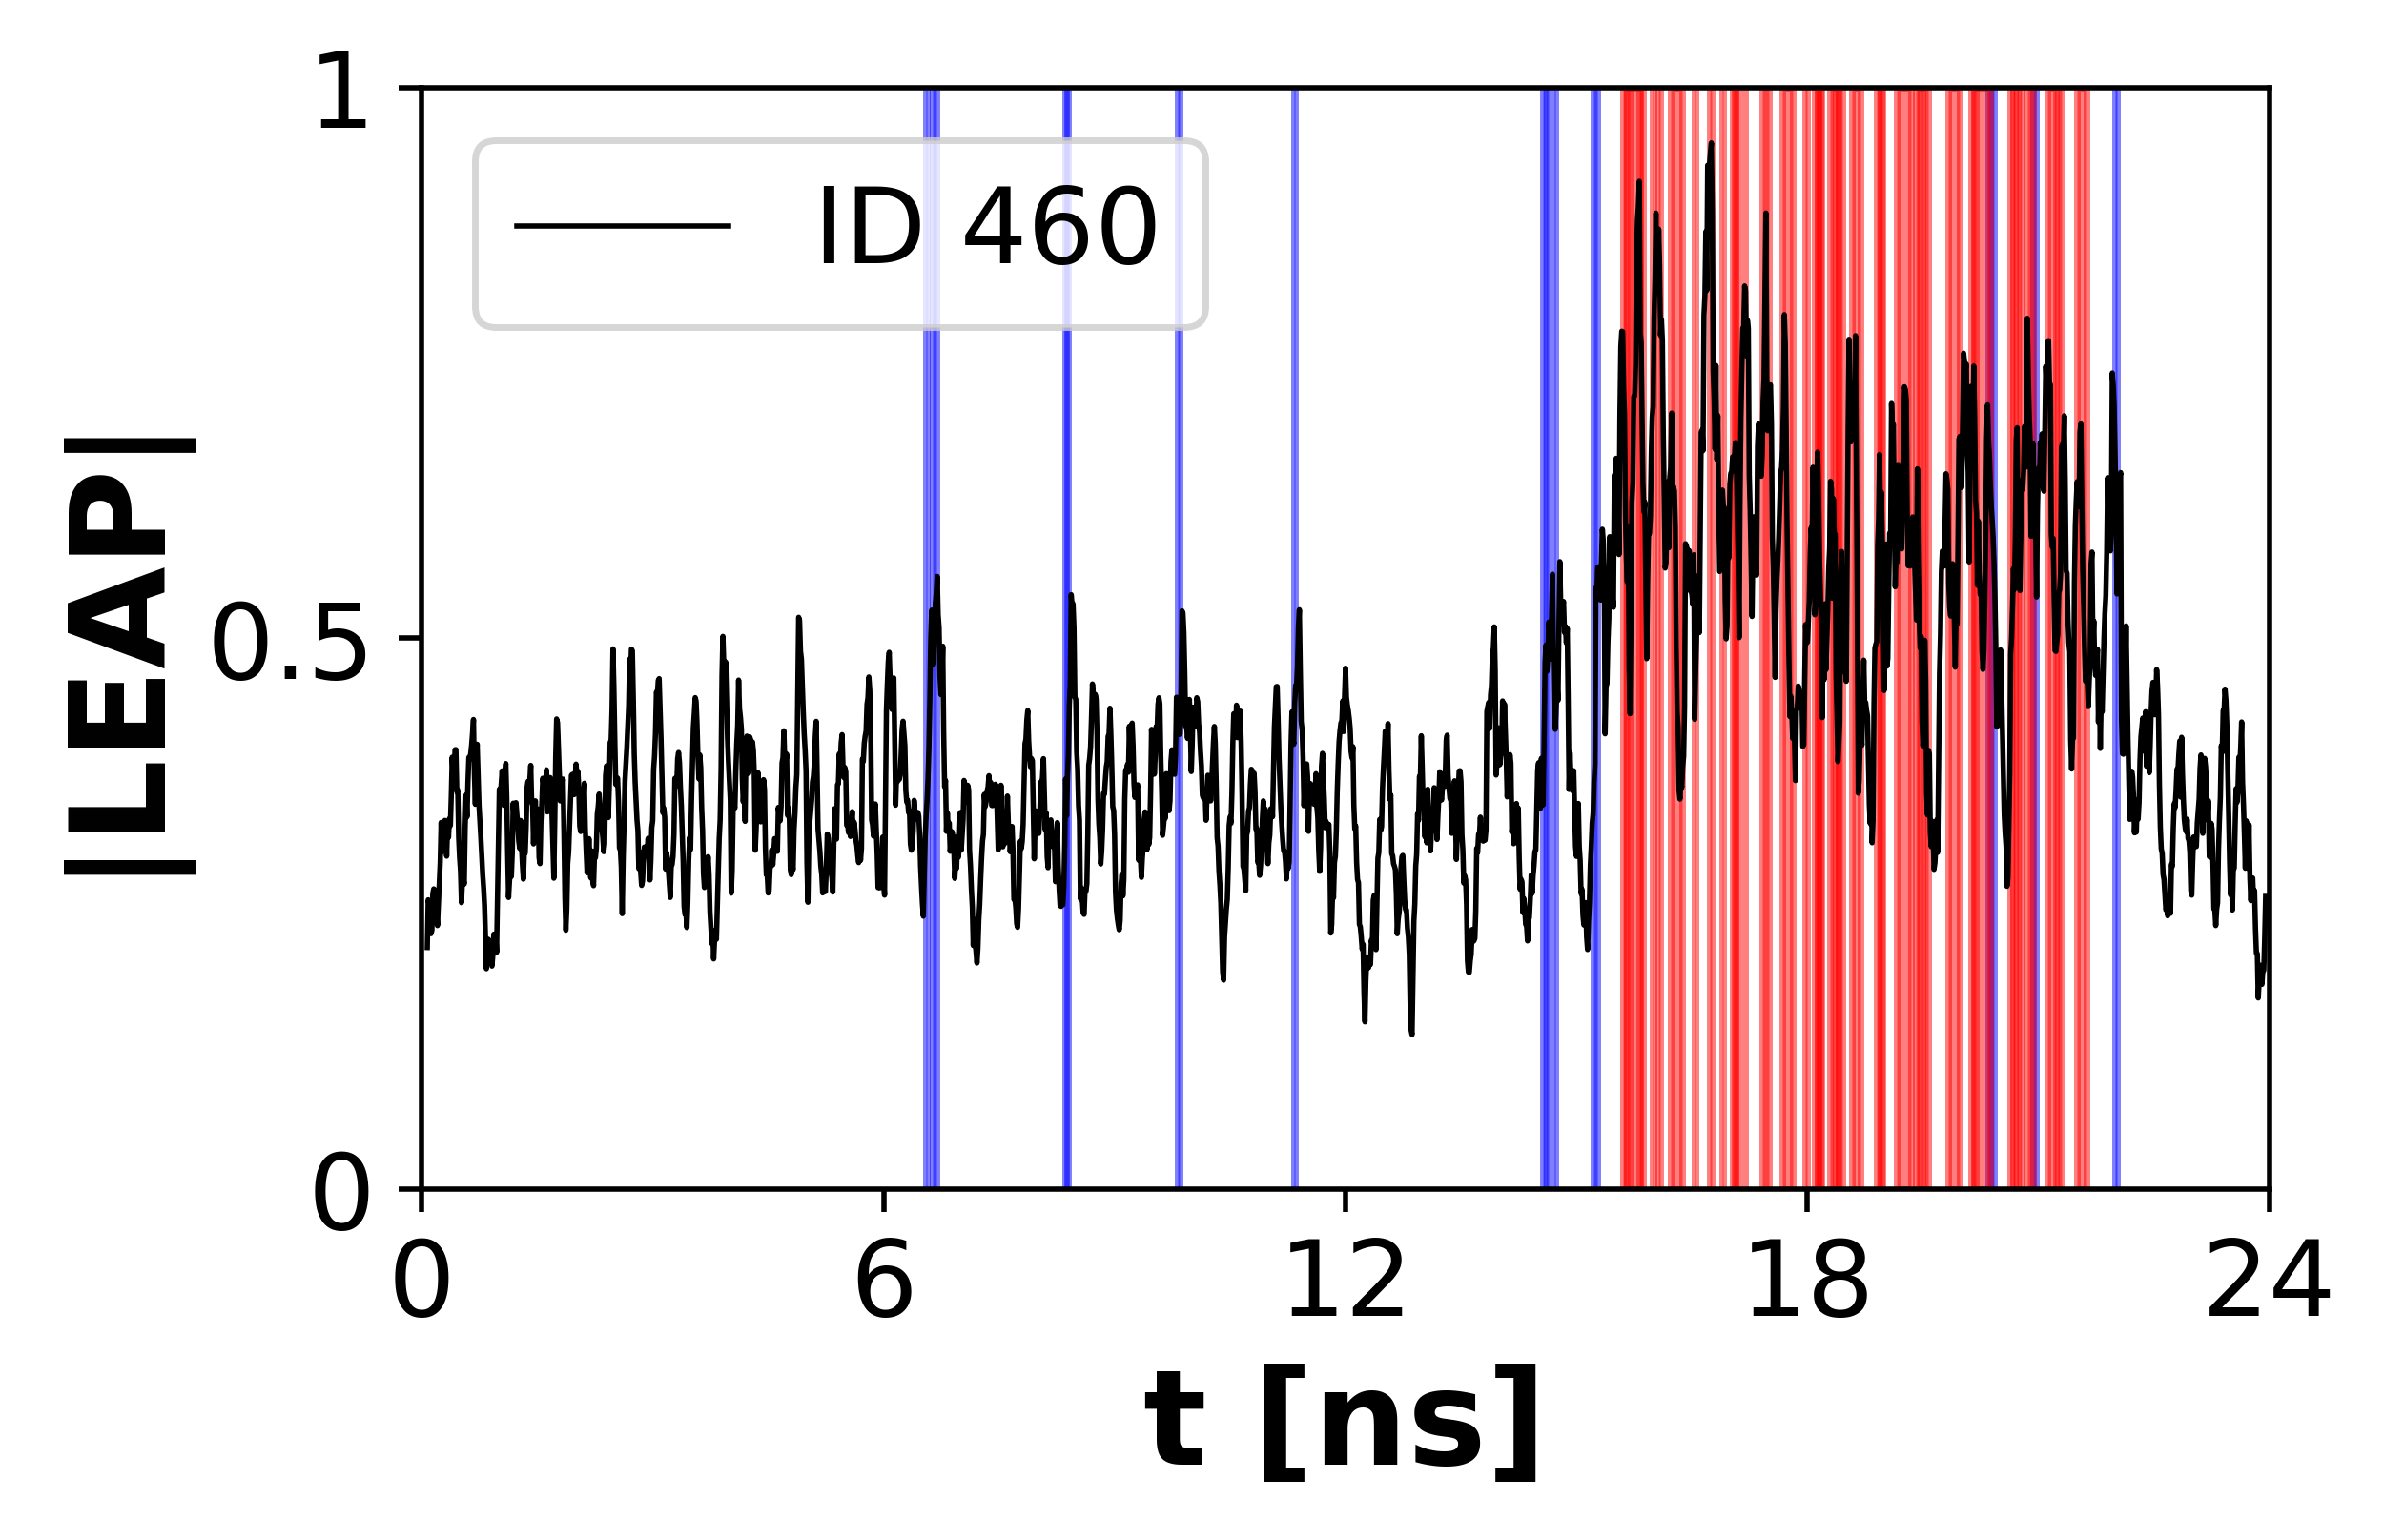

In [93]:
fig, axes = plt.subplots(
    1, figsize=(5, 3), dpi=500
)

    
axes.plot(
        time,
        ts_LEAP[460],
        color="black",
        linewidth=0.8,
        alpha=1,
        label='ID 460')


count = 0
for i in range(0, len(ts_LEAP[460])):
    if tSOAP_rolling_norm[460][i] > Sup_thr_tSOAP and LENS_rolling_norm[460][i] < Inf_thr_LENS:
        first_step_tSOAP = i
        count = count + 1
    else:
        if count != 0:
            axes.axvspan(first_step_tSOAP, first_step_tSOAP+count, alpha=0.5, color="blue")
            count = 0
        if count == 0:
            pass
        
count = 0
for i in range(0, len(ts_LEAP[460])):
    if LENS_rolling_norm[460][i] > Sup_thr_LENS and tSOAP_rolling_norm[460][i] < Inf_thr_tSOAP:
        first_step_LENS = i
        count = count + 1
    else:
        if count != 0:
            axes.axvspan(first_step_LENS, first_step_LENS+count, alpha=0.5, color="red")
            count = 0
        if count == 0:
            pass
        
               

axes.set_xlim(savGolPrint[0]+window_length // 2, savGolPrint[-1]+window_length // 2)
axes.set_xlabel(r't [ns]', weight='bold', size=20)
xticks = np.array([0, 500, 1000, 1500, 2000])
axes.set_xticks(xticks)
axes.set_xticklabels(xticks*12 //1000, fontsize=16)

axes.set_ylabel(r'|LEAP|', weight='bold', size=20)
axes.set_yticks([0, 0.5, 1])
axes.set_yticklabels([0,0.5,1], fontsize=16)
axes.set_ylim((0,1))


plt.subplots_adjust(wspace=0.08)
plt.legend(fontsize=16, loc='upper left')
plt.savefig(XYZ_OUTDIR+'Figure/blue_red_spikes.png', bbox_inches='tight')

In [94]:
time = np.arange(0, 1991)

In [95]:
particle = 826

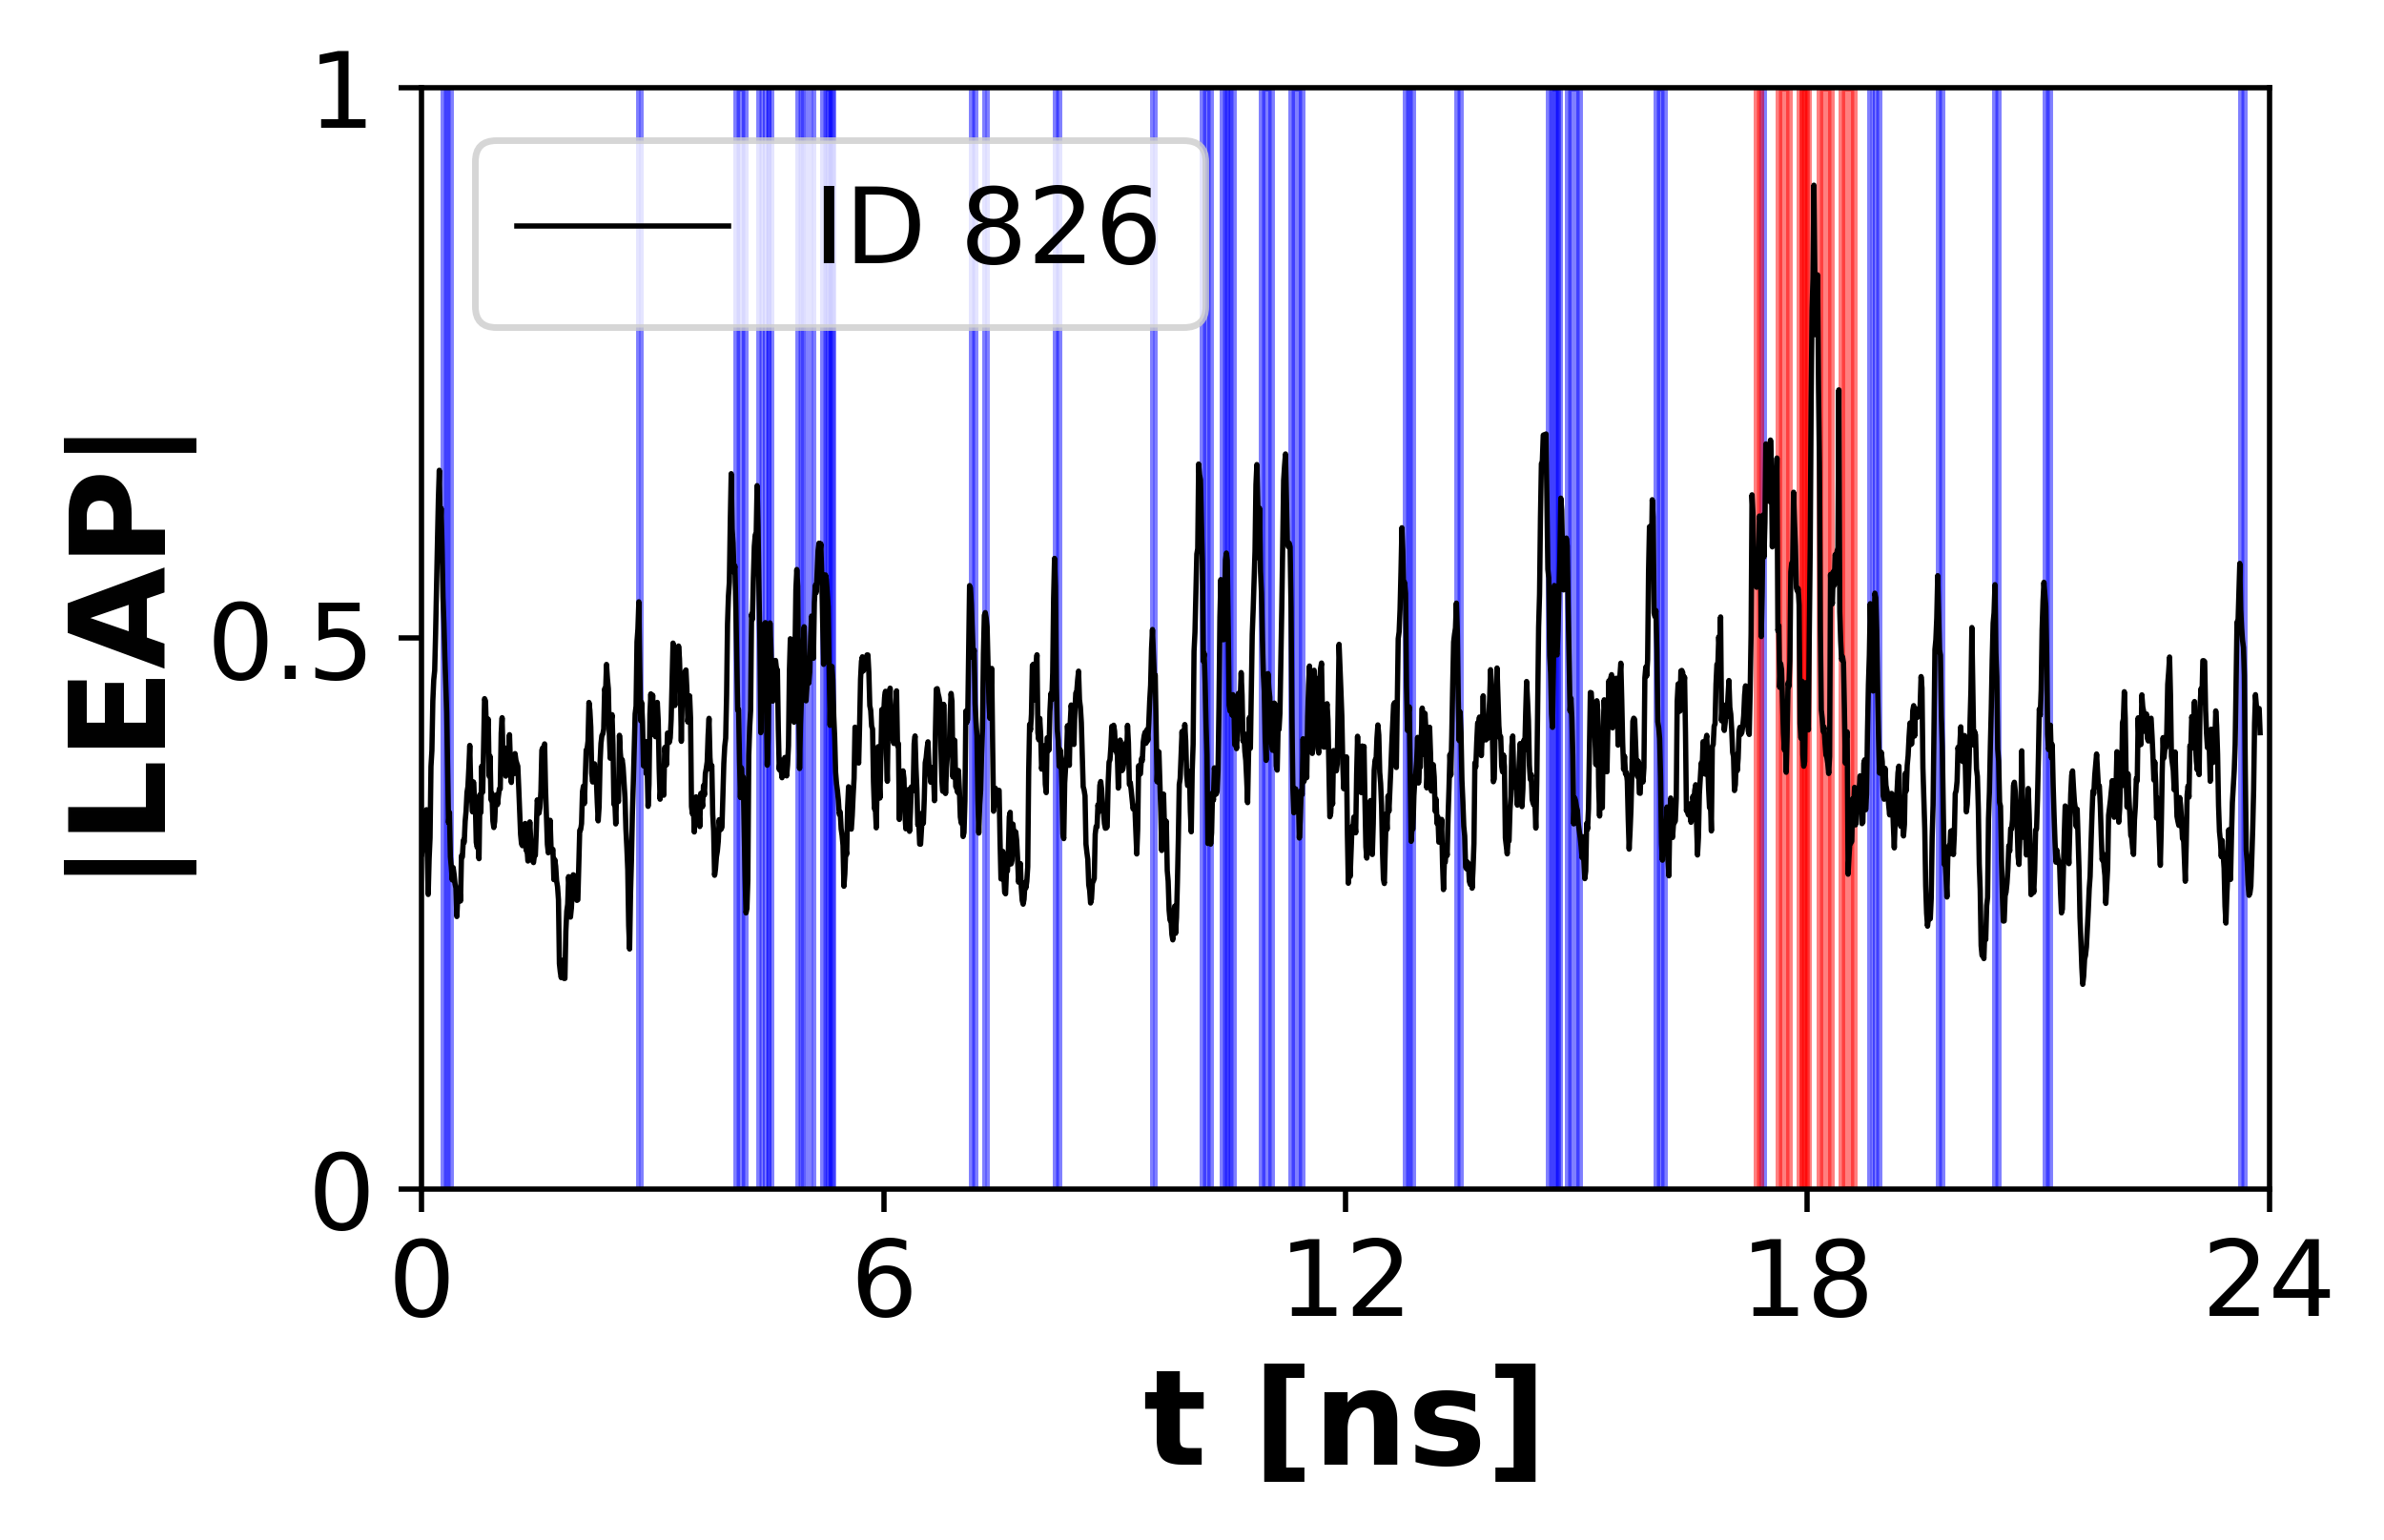

In [96]:
fig, axes = plt.subplots(
    1, figsize=(5, 3), dpi=500
)

    
axes.plot(
        time,
        ts_LEAP[particle],
        color="black",
        linewidth=0.8,
        alpha=1,
        label='ID 826')


count = 0
for i in range(0, len(ts_LEAP[particle])):
    if tSOAP_rolling_norm[particle][i] > Sup_thr_tSOAP and LENS_rolling_norm[particle][i] < Inf_thr_LENS:
        first_step_tSOAP = i
        count = count + 1
    else:
        if count != 0:
            axes.axvspan(first_step_tSOAP, first_step_tSOAP+count, alpha=0.5, color="blue")
            count = 0
        if count == 0:
            pass
        
count = 0
for i in range(0, len(ts_LEAP[particle])):
    if LENS_rolling_norm[particle][i] > Sup_thr_LENS and tSOAP_rolling_norm[particle][i] < Inf_thr_tSOAP:
        first_step_LENS = i
        count = count + 1
    else:
        if count != 0:
            axes.axvspan(first_step_LENS, first_step_LENS+count, alpha=0.5, color="red")
            count = 0
        if count == 0:
            pass
        
               

axes.set_xlim(savGolPrint[0]+window_length // 2, savGolPrint[-1]+window_length // 2)
axes.set_xlabel(r't [ns]', weight='bold', size=20)
xticks = np.array([0, 500, 1000, 1500, 2000])
axes.set_xticks(xticks)
axes.set_xticklabels(xticks*12 //1000, fontsize=16)

axes.set_ylabel(r'|LEAP|', weight='bold', size=20)
axes.set_yticks([0, 0.5, 1])
axes.set_yticklabels([0,0.5,1], fontsize=16)
axes.set_ylim((0,1))


plt.subplots_adjust(wspace=0.08)
plt.legend(fontsize=16, loc='upper left')
plt.savefig(XYZ_OUTDIR+'Figure/blue_red_spikes_826.png', bbox_inches='tight')

In [97]:
count_blue_general = []
dt_blue_general = []
frame_blue_particle_general_per_particle = []

for particle in range(0, np.shape(djoint_d)[1]):
    count = 0
    frame_blue_particle_general = []
    dt_blue_general_particle = []
    for i in range(0, np.shape(djoint_d)[0]):
        if djoint_d[i, particle, 0] > Sup_thr_tSOAP and djoint_d[i, particle, 1] < Inf_thr_LENS:
            count = count + 1
            frame_blue_particle_general.append(i)
    if count > 2:
        count_blue_general.append(count)
        dt_blue_general_particle = np.diff(frame_blue_particle_general)
        dt_blue_general.append(np.mean(dt_blue_general_particle))
        frame_blue_particle_general_per_particle.append(frame_blue_particle_general)


In [98]:
tau_sf_avg = np.mean(dt_blue_general)
tau_sf_avg

43.500117296423795

In [99]:
len(frame_blue_particle_general_per_particle)

213

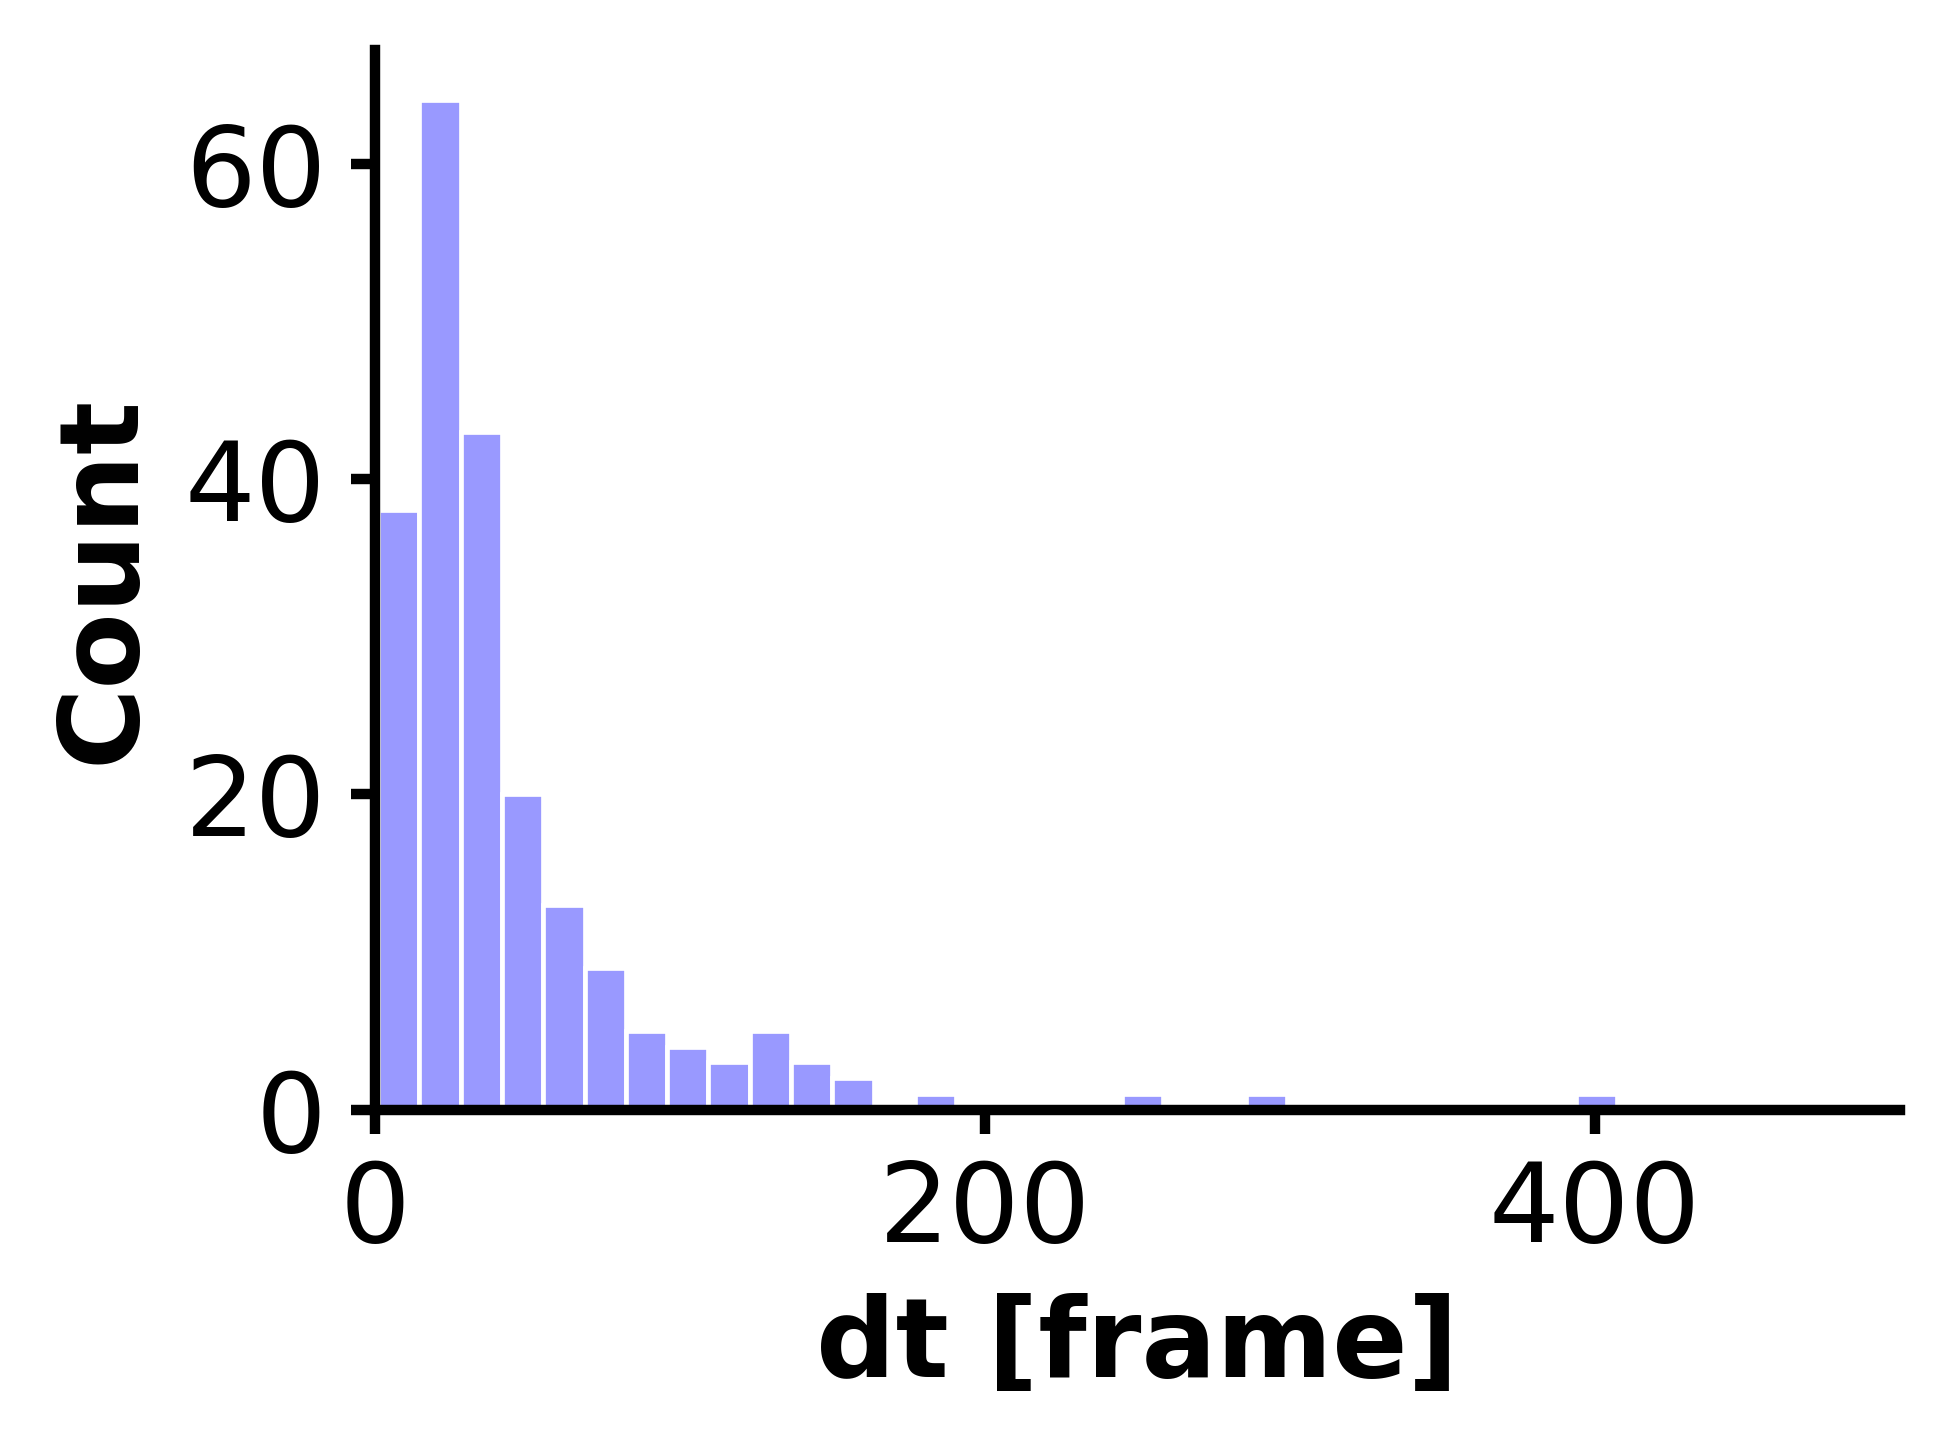

In [100]:
fig, ax = plt.subplots(1, figsize=(4,3), dpi=500, tight_layout=True)
# sns.kdeplot(data=distance, color='black', bw_adjust=0.4, linewidth=2, fill=False)

# ax.set_xlim(0, 1)
# ax.set_ylim(0, 4)
ax.set_xlabel('dt [frame]', weight='bold', size=16)
# xticks = [0, 50, 100, 150]
# ax.set_xticks(xticks)
# ax.set_xticklabels([0, 50*0.012, 100*0.012, 150*0.012], size=12)
ax.set_ylabel('Count', weight='bold', size=16)
# ax.set_yticks([])

hist = sns.histplot(data=dt_blue_general, alpha=0.4, edgecolor='white', color='blue', bins=30, stat='count', kde=False)
# ax2 = ax.twiny()
# my_kde = sns.kdeplot(data=count_blue, bw_adjust=0.3, linewidth=1, color='blue', gridsize=500, ax=ax,)
# plt.hist(x=count_blue, bins=50, color='blue', edgecolor='black', linewidth=0.5,
#                             alpha=0.7, rwidth=0.9)

ax.set_xlim(0, 500)
# ax.set_ylim(0, 1)
for side in ['right','top']:
    ax.spines[side].set_visible(False)
for side in ['bottom','right','top','left']:
    ax.spines[side].set_linewidth(1.5)
    
ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=True,
    left=True,      
    labelleft=True,
    labelbottom=True,
    width=1.5,
    labelsize=16,
) 

In [101]:
countB_general, bins_countB_general = np.histogram(dt_blue_general, bins=100) 
  
# finding the PDF of the histogram using count values 
pdfB_general = countB_general / sum(countB_general) 
  
# using numpy np.cumsum to calculate the CDF 
# We can also find using the PDF values by looping and adding 
cdfB_general = np.cumsum(pdfB_general) 
  
# plotting PDF and CDF 
# plt.plot(bins_countB_general[1:], cdf, label="CDF") 
    
    

/tmp/ipykernel_19289/3907845229.py:23: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes.set_xlim(0, 500)


Text(0, 0.5, '$P_{n>=1}$')

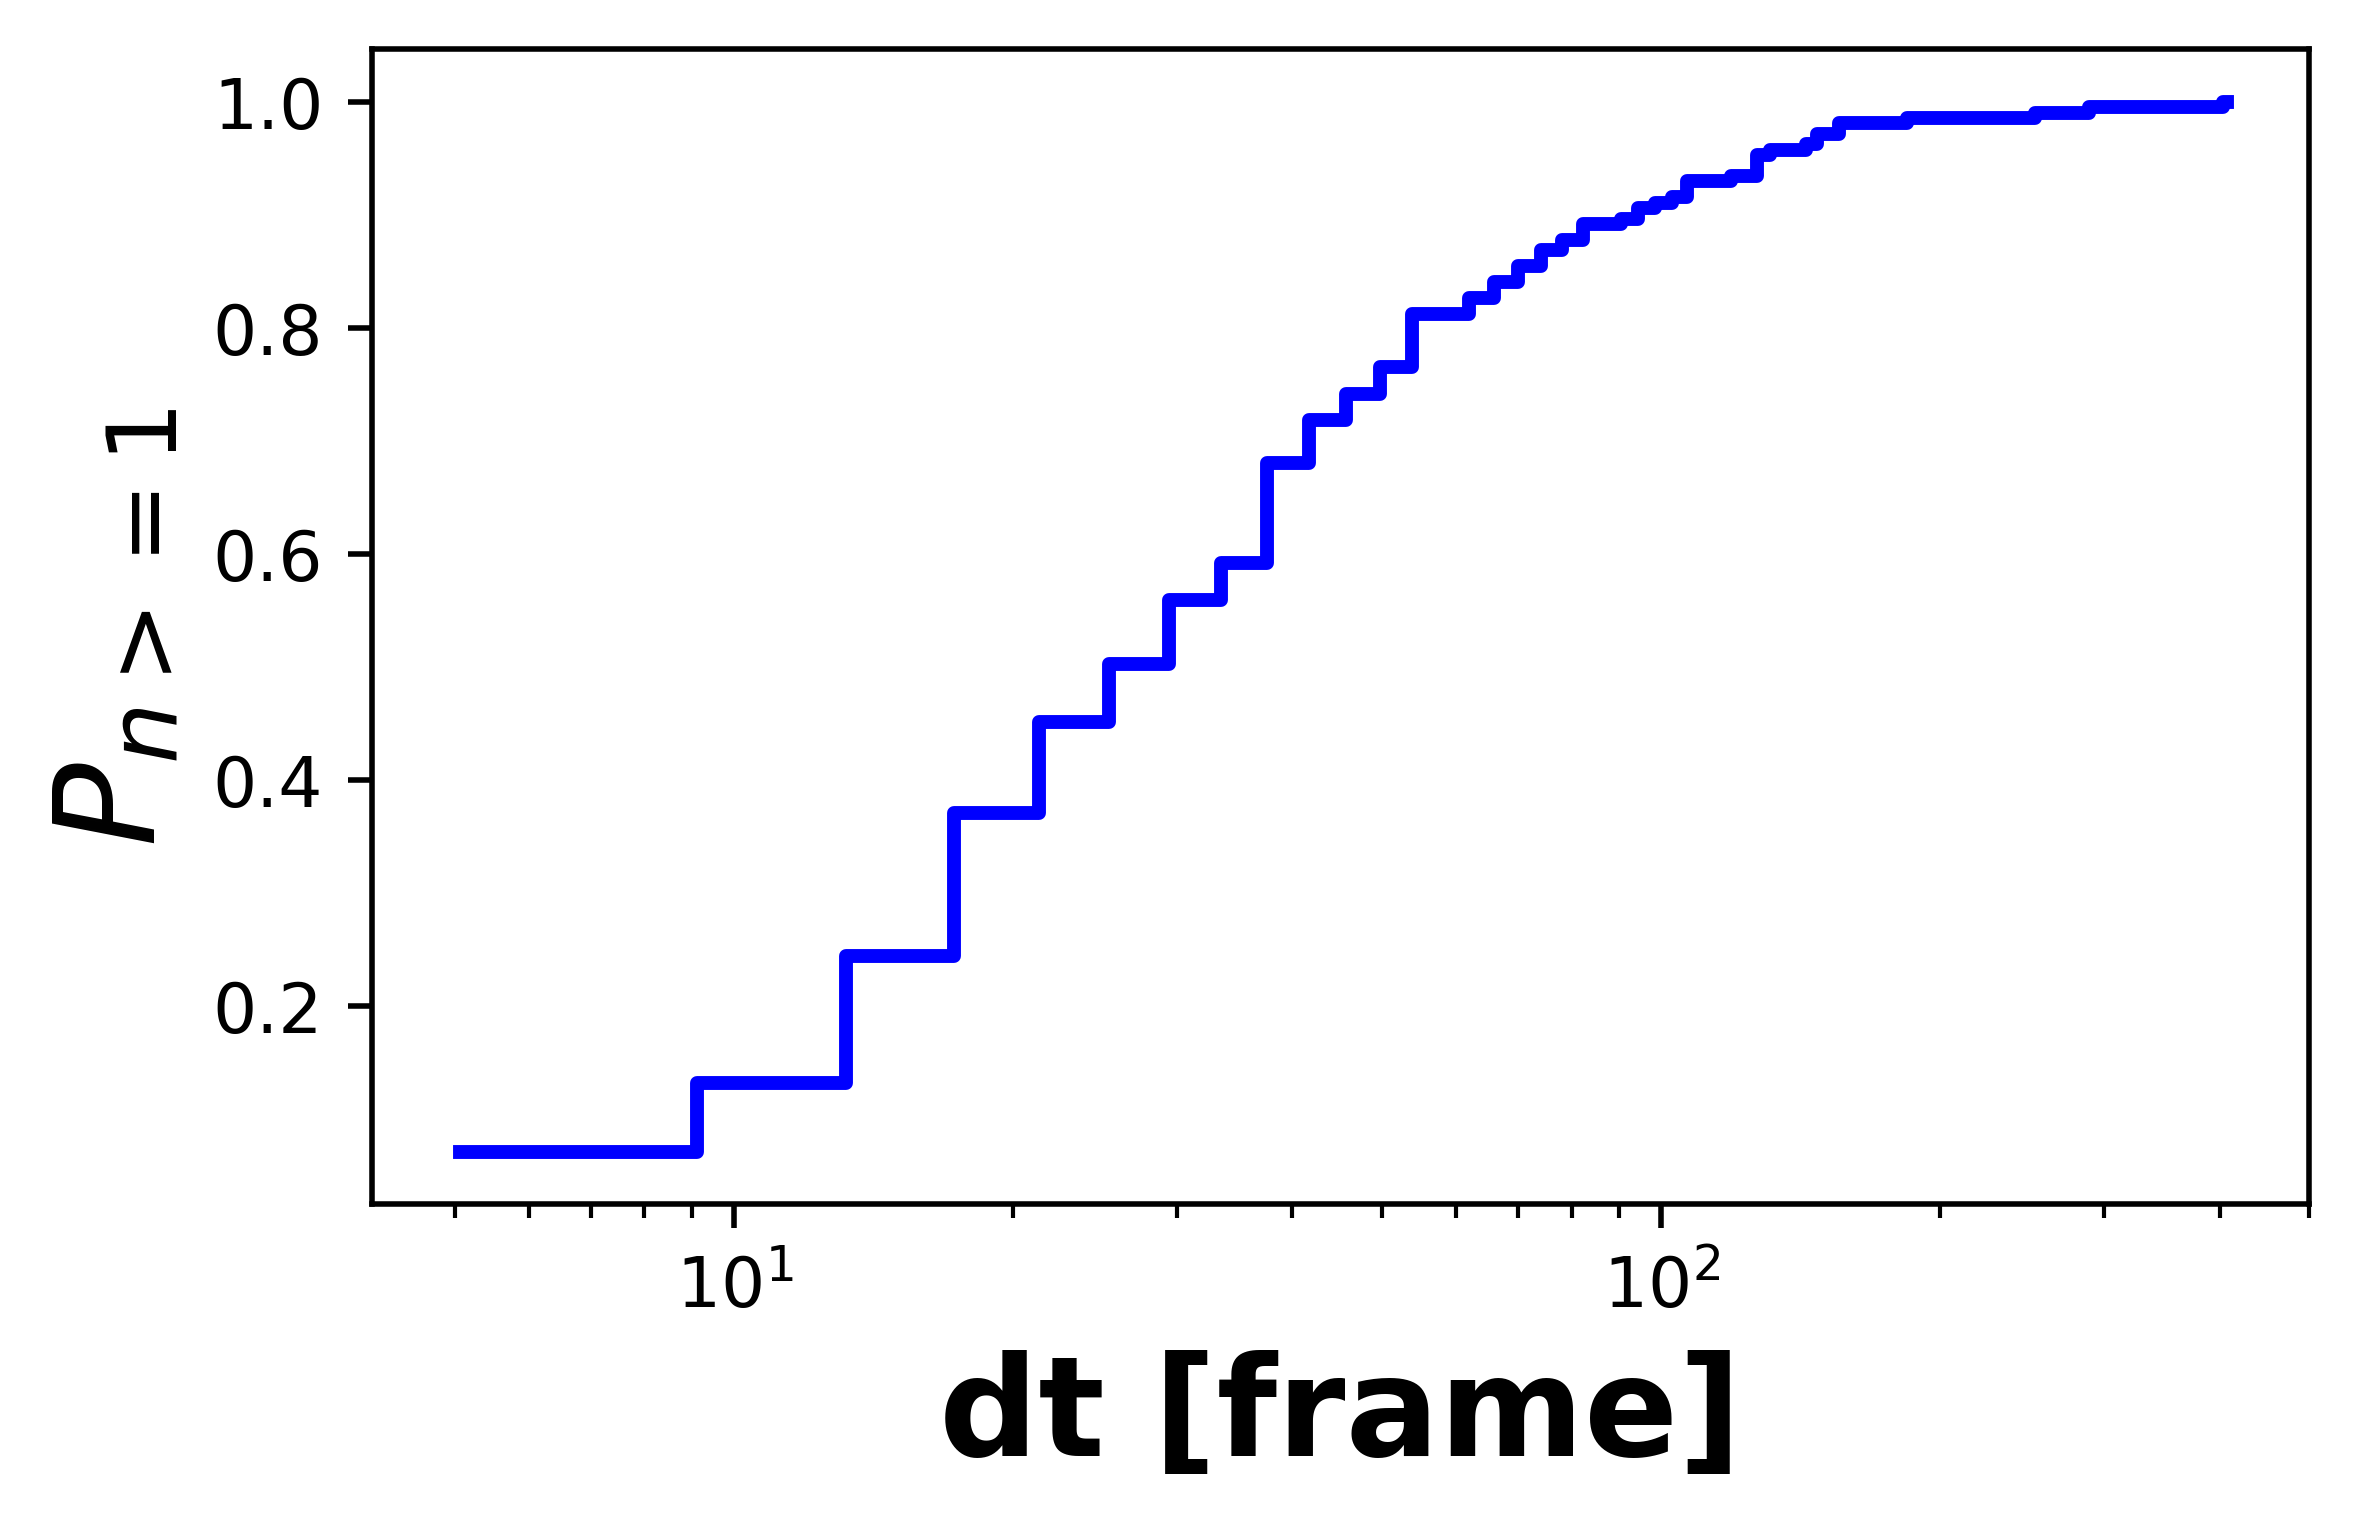

In [102]:
fig, axes = plt.subplots(
    1, figsize=(5, 3), dpi=500
)

    
axes.step(
        bins_countB_general[1:],
        cdfB_general,
        color="blue",
        linewidth=2,
        alpha=1)
        
               




axes.set_xlabel(r'dt [frame]', weight='bold', size=20)
# xticks = np.array([0, 50, 100, 150, 200])
# axes.set_xticks(xticks)
# axes.set_xticklabels([0, 50, 100, 150, 200], fontsize=16)
plt.xscale('log')
axes.set_xlim(0, 500)

axes.set_ylabel(r'$P_{n>=1}$', weight='bold', size=20)

In [103]:
# How many BLUE attempts before the RED region?
count_blue = []
red_particle_reduced = []  # Only particles going through the red region after a bit (not at the beginning of the analysed MD trj)
dt_blue = []
frame_red = []
frame_blue_particle_per_particle = []
count_blue_attempts_within_tau_avg = []

for particle in red_particle:
    count = 0
    found_red = 0
    frame_blue_particle = []
    count_tmp = 0
    for i in range(0, np.shape(djoint_d)[0]):
        if djoint_d[i, particle, 1] > Sup_thr_LENS and djoint_d[i, particle, 0] < Inf_thr_tSOAP:
            found_red = 1
        if djoint_d[i, particle, 0] > Sup_thr_tSOAP and djoint_d[i, particle, 1] < Inf_thr_LENS and found_red == 0:
            count = count + 1
            frame_blue_particle.append(i)
        if found_red == 1 and count != 0:
            count_blue.append(count)
            frame_red.append(i)
            red_particle_reduced.append(particle)
            frame_blue_particle_per_particle.append(frame_blue_particle)
            dt_blue_particle = np.diff(frame_blue_particle)
            dt_blue.append(np.mean(dt_blue_particle))
            
            for j in range(0, len(frame_blue_particle)):
                if frame_blue_particle[j] > i-tau_sf_avg:
                    count_tmp = count_tmp + 1
            count_blue_attempts_within_tau_avg.append(count_tmp)
            break

In [104]:
frame_red

[571,
 350,
 1448,
 1813,
 1834,
 1279,
 1987,
 814,
 944,
 654,
 1356,
 282,
 1442,
 1549,
 86]

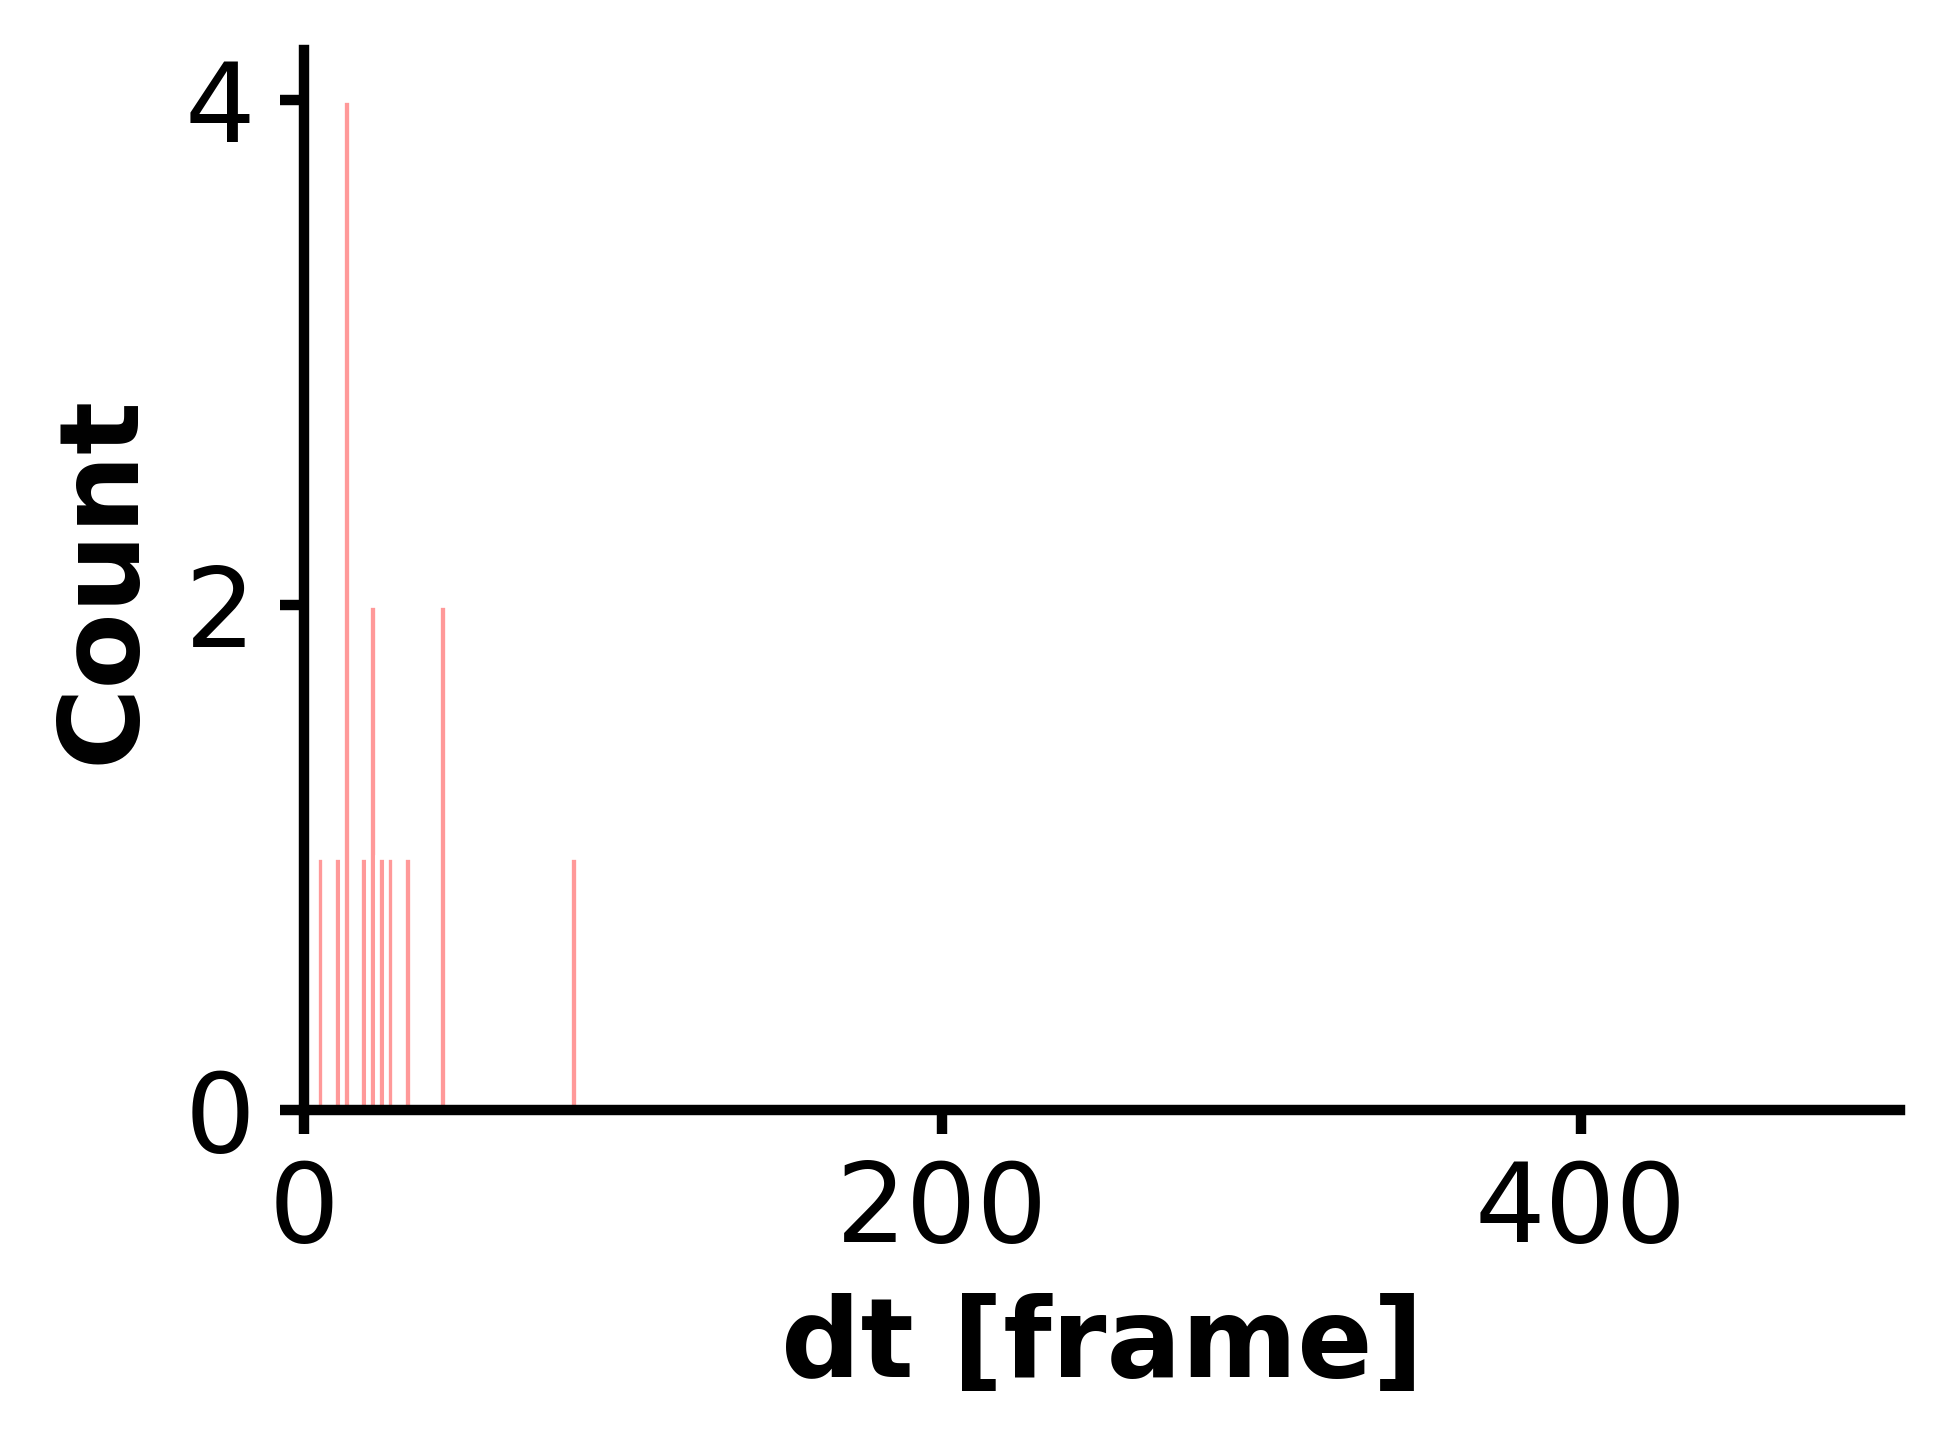

In [105]:
fig, ax = plt.subplots(1, figsize=(4,3), dpi=500, tight_layout=True)
# sns.kdeplot(data=distance, color='black', bw_adjust=0.4, linewidth=2, fill=False)

# ax.set_xlim(0, 1)
# ax.set_ylim(0, 4)
ax.set_xlabel('dt [frame]', weight='bold', size=16)
# xticks = [0, 50, 100, 150]
# ax.set_xticks(xticks)
# ax.set_xticklabels([0, 50*0.012, 100*0.012, 150*0.012], size=12)
ax.set_ylabel('Count', weight='bold', size=16)
# ax.set_yticks([])

hist = sns.histplot(data=dt_blue, alpha=0.4, edgecolor='white', color='red', bins=30, stat='count', kde=False)
# ax2 = ax.twiny()
# my_kde = sns.kdeplot(data=count_blue, bw_adjust=0.3, linewidth=1, color='blue', gridsize=500, ax=ax,)
# plt.hist(x=count_blue, bins=50, color='blue', edgecolor='black', linewidth=0.5,
#                             alpha=0.7, rwidth=0.9)

ax.set_xlim(0, 500)
# ax.set_ylim(0, 1)
for side in ['right','top']:
    ax.spines[side].set_visible(False)
for side in ['bottom','right','top','left']:
    ax.spines[side].set_linewidth(1.5)
    
ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=True,
    left=True,      
    labelleft=True,
    labelbottom=True,
    width=1.5,
    labelsize=16,
) 

In [106]:
countB, bins_countB = np.histogram(dt_blue, bins=15) 
  
# finding the PDF of the histogram using count values 
pdfB = countB / sum(countB) 
  
# using numpy np.cumsum to calculate the CDF 
# We can also find using the PDF values by looping and adding 
cdfB = np.cumsum(pdfB) 
  
# plotting PDF and CDF 
# plt.plot(bins_countB_general[1:], cdf, label="CDF") 
    

In [107]:
count_blue

[18, 8, 105, 95, 36, 18, 85, 49, 28, 25, 43, 13, 134, 15, 14]

/tmp/ipykernel_19289/226078374.py:23: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes.set_xlim(0, 500)


Text(0, 0.5, '$P_{n>=1}$')

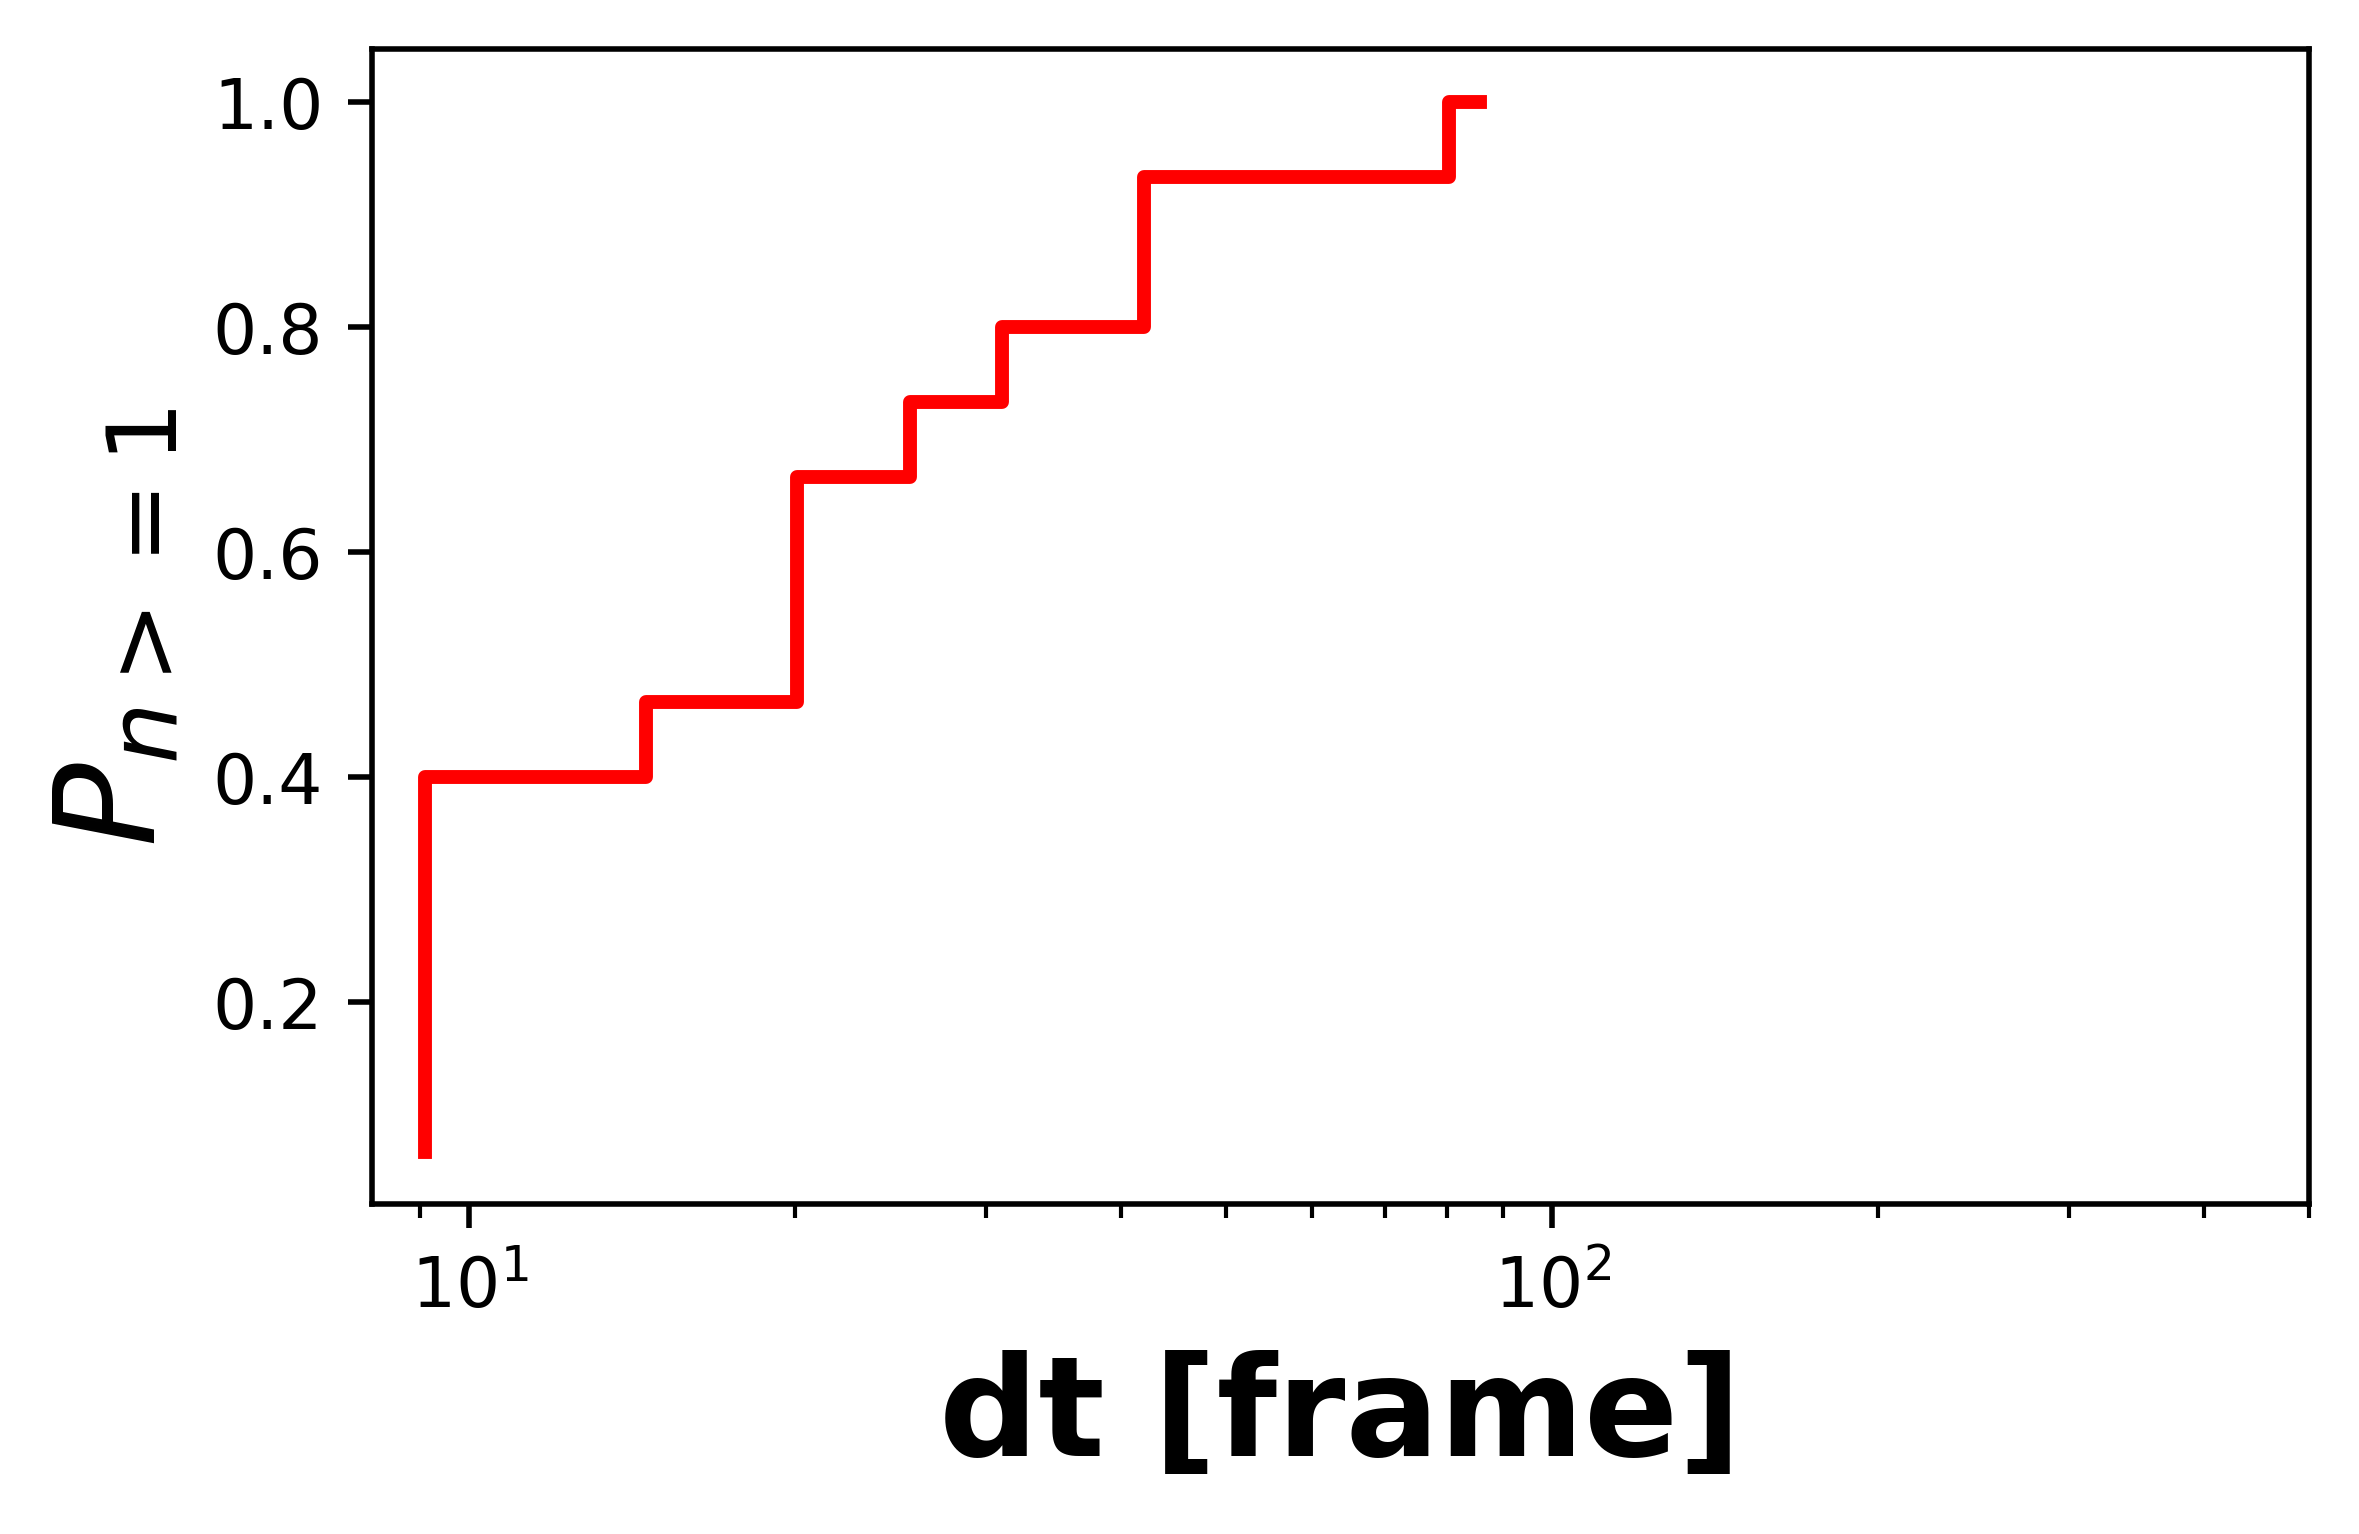

In [108]:
fig, axes = plt.subplots(
    1, figsize=(5, 3), dpi=500
)

    
axes.step(
        bins_countB[1:],
        cdfB,
        color="red",
        linewidth=2,
        alpha=1)
        
               




axes.set_xlabel(r'dt [frame]', weight='bold', size=20)
# xticks = np.array([0, 50, 100, 150, 200])
# axes.set_xticks(xticks)
# axes.set_xticklabels([0, 50, 100, 150, 200], fontsize=16)
plt.xscale('log')
axes.set_xlim(0, 500)

axes.set_ylabel(r'$P_{n>=1}$', weight='bold', size=20)

In [109]:
countR, bins_countR = np.histogram(frame_red, bins=15) 
  
# finding the PDF of the histogram using count values 
pdfR = countR / sum(countR) 
  
# using numpy np.cumsum to calculate the CDF 
# We can also find using the PDF values by looping and adding 
cdfR = np.cumsum(pdfR) 

Text(0, 0.5, '$P_{n>=1}$')

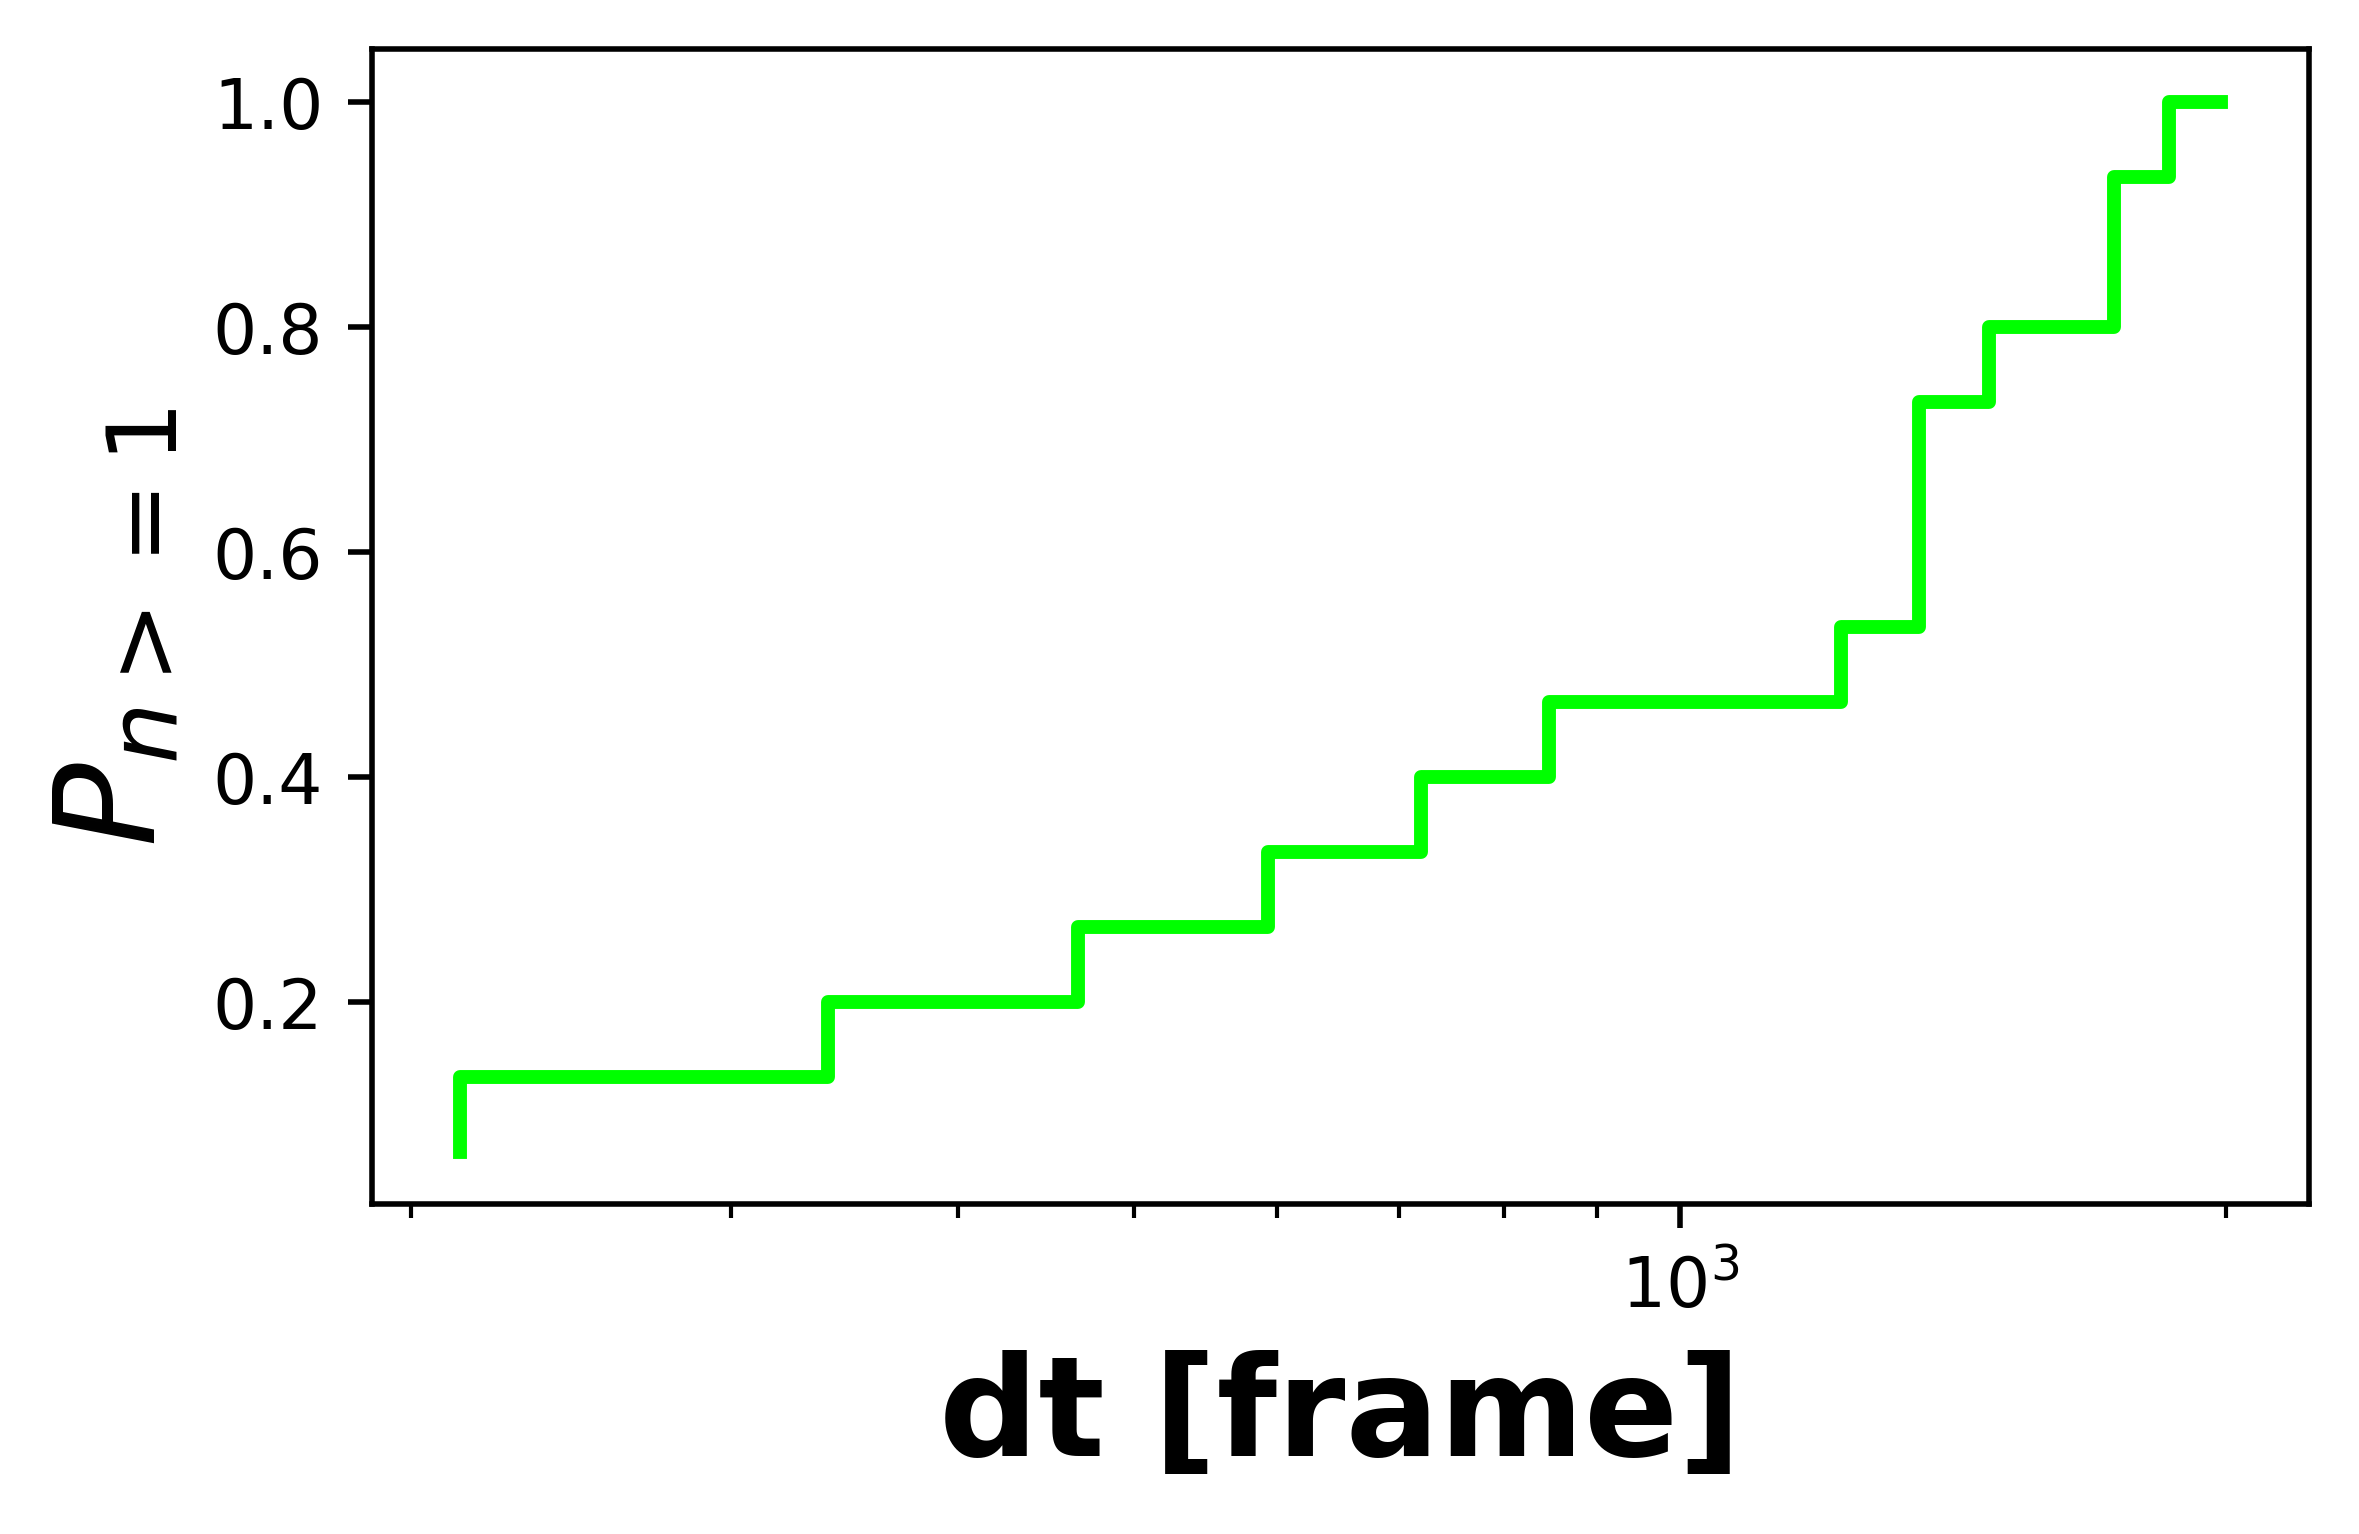

In [110]:
fig, axes = plt.subplots(
    1, figsize=(5, 3), dpi=500
)

    
axes.step(
        bins_countR[1:],
        cdfR,
        color="lime",
        linewidth=2,
        alpha=1)
        
               




axes.set_xlabel(r'dt [frame]', weight='bold', size=20)
# xticks = np.array([0, 50, 100, 150, 200])
# axes.set_xticks(xticks)
# axes.set_xticklabels([0, 50, 100, 150, 200], fontsize=16)
plt.xscale('log')
# axes.set_xlim(0, 500)

axes.set_ylabel(r'$P_{n>=1}$', weight='bold', size=20)

In [111]:
countB_beforeR, bins_countB_beforeR = np.histogram(count_blue, bins=15) 
  
# finding the PDF of the histogram using count values 
pdfB_beforeR = countB_beforeR / sum(countB_beforeR) 
  
# using numpy np.cumsum to calculate the CDF 
# We can also find using the PDF values by looping and adding 
cdfB_beforeR = np.cumsum(pdfB_beforeR) 

In [112]:
bins_countB_general = np.append([0], bins_countB_general, axis=0)
cdfB_general = np.append([0], cdfB_general, axis=0)

bins_countB = np.append([0], bins_countB, axis=0)
cdfB = np.append([0], cdfB, axis=0)

bins_countR = np.append([0], bins_countR, axis=0)
cdfR = np.append([0], cdfR, axis=0)

In [113]:
bins_countB_beforeR = np.append([0], bins_countB_beforeR, axis=0)
cdfB_beforeR = np.append([0], cdfB_beforeR, axis=0)

/tmp/ipykernel_19289/3638187995.py:33: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes.set_xlim(0, 2000)


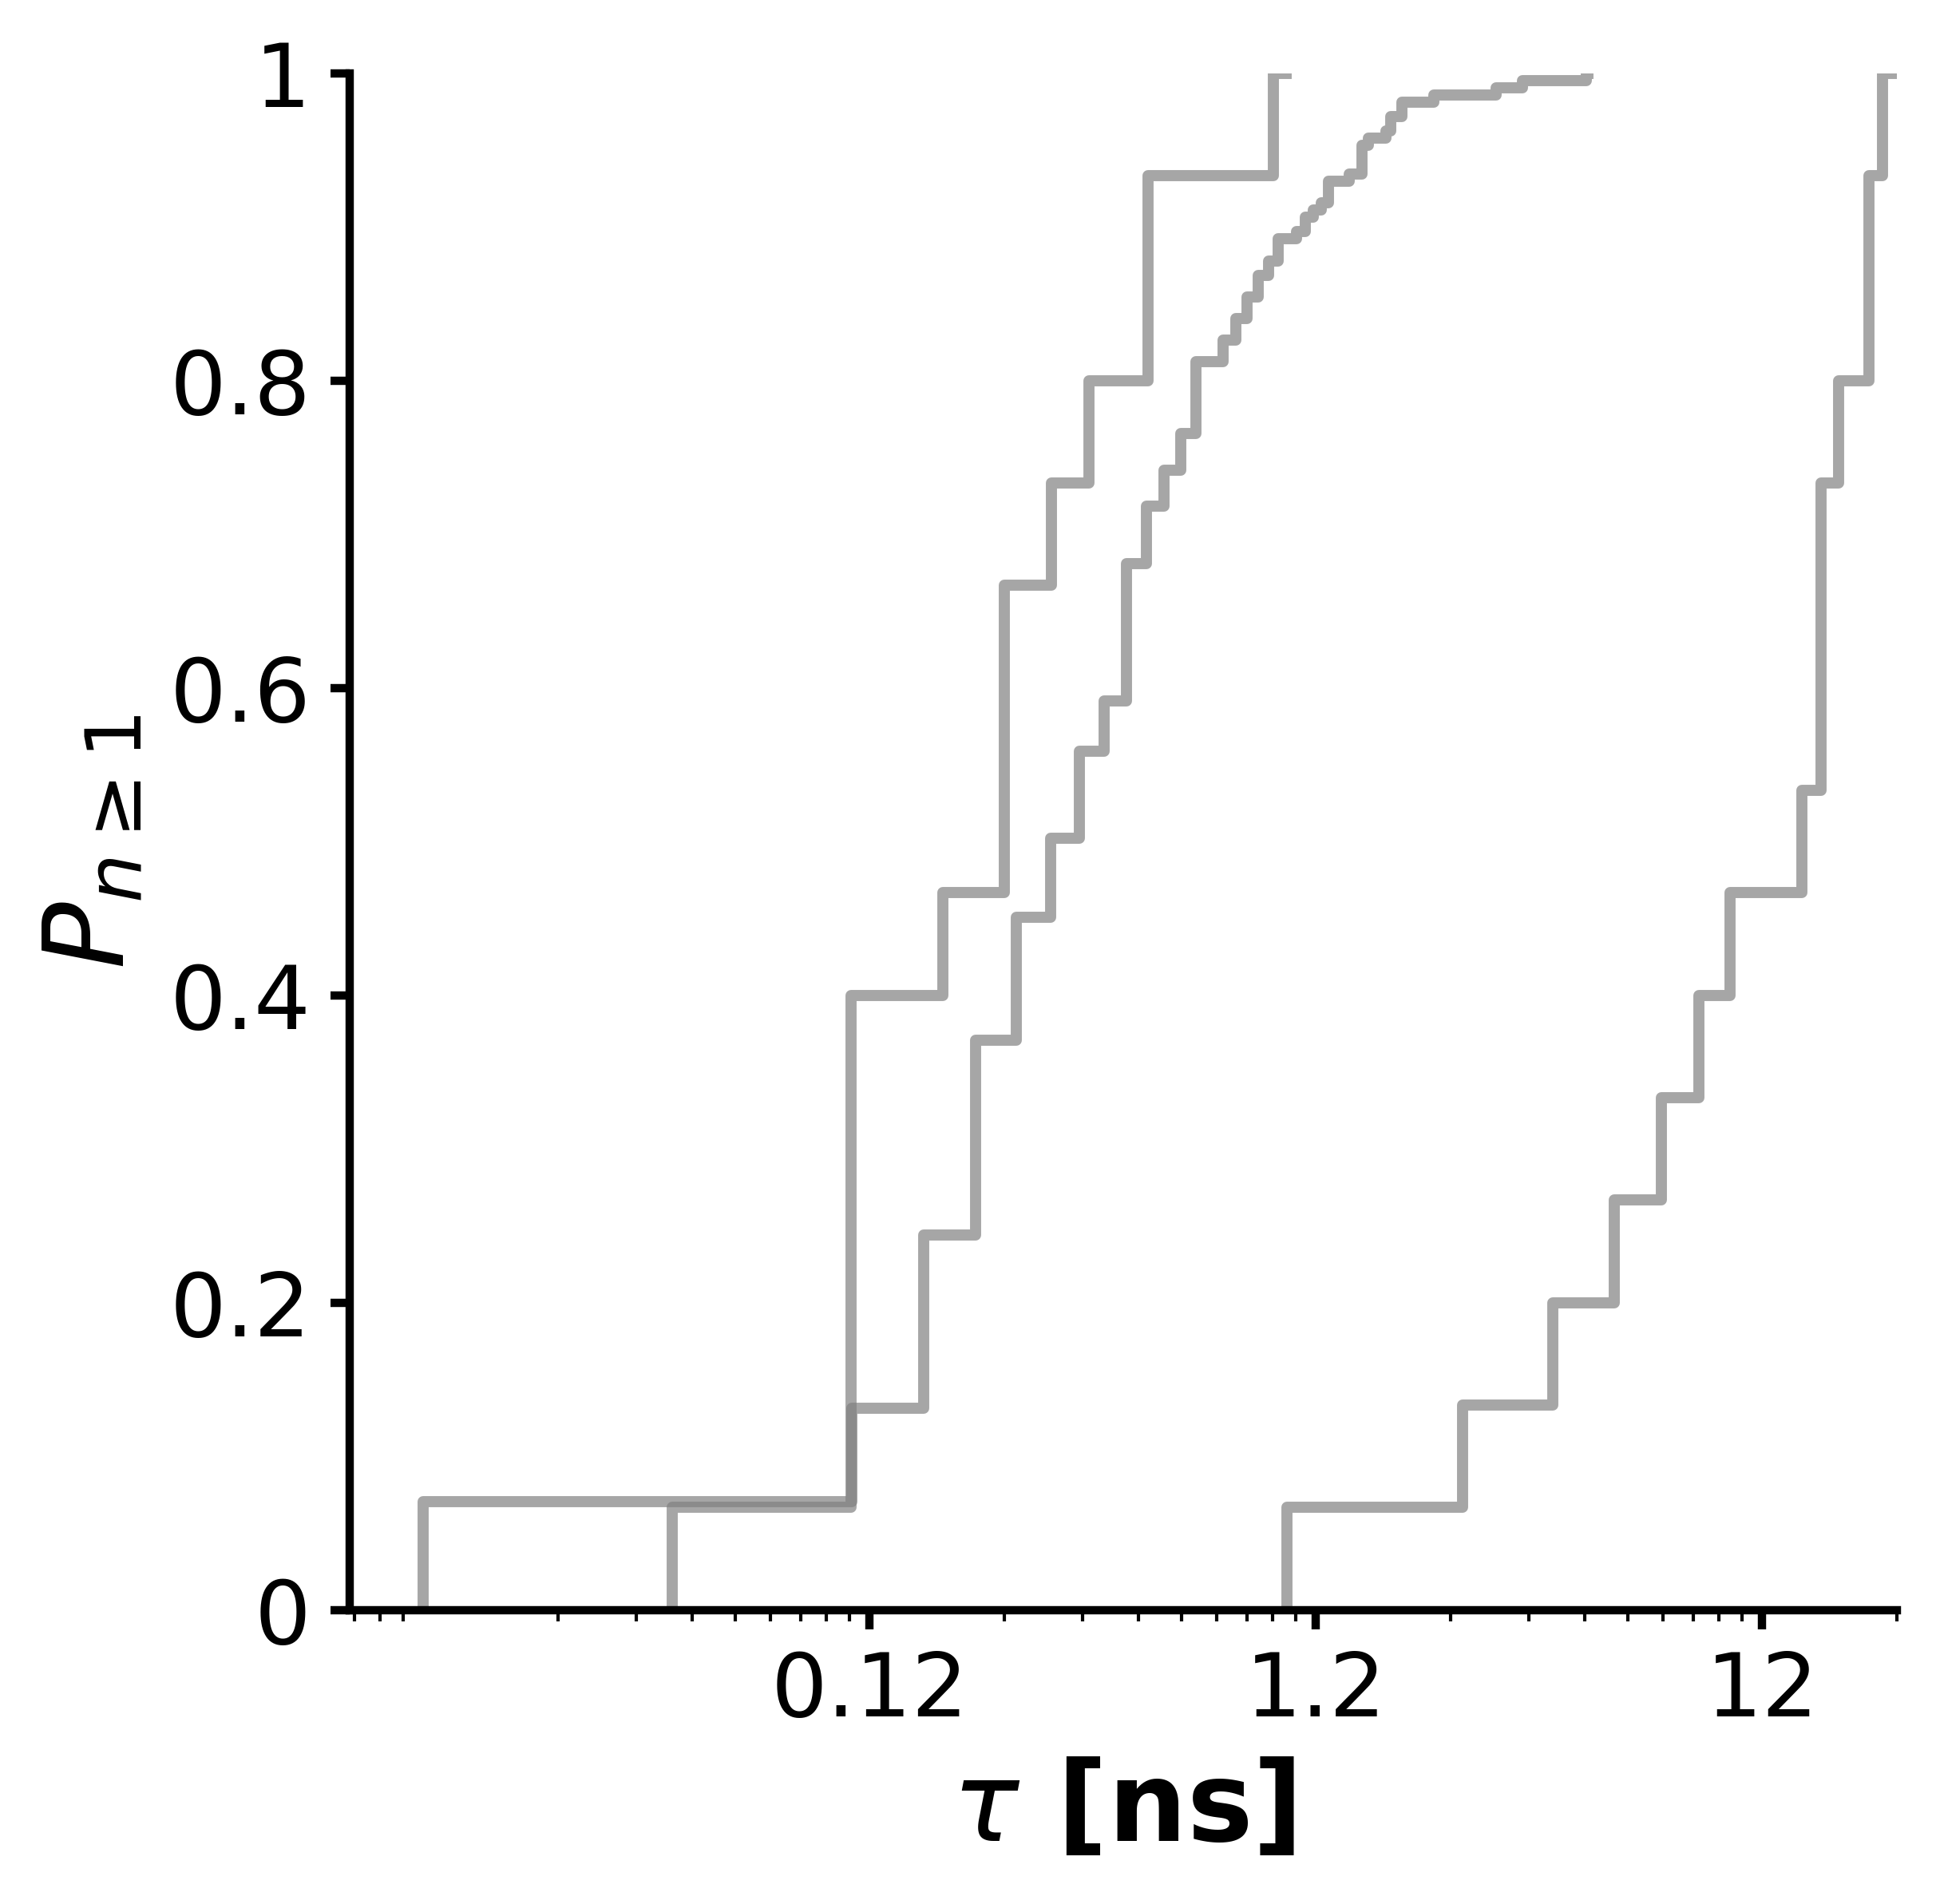

In [114]:
fig, axes = plt.subplots(
    1, figsize=(5, 5), dpi=500
)

axes.step(
        bins_countB_general[1:],
        cdfB_general,
        color="gray",
        linewidth=2,
        alpha=0.7)


axes.step(
        bins_countB[1:],
        cdfB,
        color="gray",
        linewidth=2,
        alpha=0.7)
        

axes.step(
        bins_countR[1:],
        cdfR,
        color="gray",
        linewidth=2,
        alpha=0.7)



axes.set_xlabel(r'$τ$ [ns]', weight='bold', size=20)

plt.xscale('log')
axes.set_xlim(0, 2000)

xticks = np.array([10, 100, 1000])
axes.set_xticks(xticks)
axes.set_xticklabels([10*12/1000, 100*12/1000, 1000*12//1000], fontsize=16)

axes.set_ylim(0, 1)

yticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
axes.set_yticks(yticks)
axes.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=16)

axes.set_ylabel(r'$P_{n\geq1}$', weight='bold', size=20)

for side in ['right','top']:
    axes.spines[side].set_visible(False)
for side in ['bottom','right','top','left']:
    axes.spines[side].set_linewidth(1.5)
    
    
axes.tick_params(
axis='both',          # changes apply to the x-axis
which='major',      # both major and minor ticks are affected
bottom=True,
left=True,      
labelleft=True,
labelbottom=True,
width=1.5,
labelsize=16,
)     
# plt.savefig(XYZ_OUTDIR+'Figure/tau.png', bbox_inches='tight')

In [115]:
np.savetxt(XYZ_OUTDIR+'x1.txt', bins_countB_general[1:])
np.savetxt(XYZ_OUTDIR+'y1.txt', cdfB_general)

np.savetxt(XYZ_OUTDIR+'x2.txt', bins_countB[1:])
np.savetxt(XYZ_OUTDIR+'y2.txt', cdfB)

np.savetxt(XYZ_OUTDIR+'x3.txt', bins_countR[1:])
np.savetxt(XYZ_OUTDIR+'y3.txt', cdfR)

In [116]:
x1_fitting_v3 = np.loadtxt(XYZ_OUTDIR+'x1_fitting_v3.txt')
fitting1_v3 = np.loadtxt(XYZ_OUTDIR+'fitting1_v3.txt')

x2_fitting_v3 = np.loadtxt(XYZ_OUTDIR+'x2_fitting_v3.txt')
fitting2_v3 = np.loadtxt(XYZ_OUTDIR+'fitting2_v3.txt')

x3_fitting = np.loadtxt(XYZ_OUTDIR+'x3_fitting.txt')
fitting3 = np.loadtxt(XYZ_OUTDIR+'fitting3.txt')

In [117]:
x1_v3 = np.arange(0, len(fitting1_v3))
x2_v3 = np.arange(0, len(fitting2_v3))
x3 = np.arange(0, len(fitting3))

In [118]:
# plot1_diff_to_add = len(x1_v2) - len(cdfB_general)
# plot2_diff_to_add = len(x1_v2) - len(cdfB)
# plot3_diff_to_add = len(x1_v2) - len(cdfR)

plot1_diff_to_add = 1
plot2_diff_to_add = 1
plot3_diff_to_add = 1

plot1_toappend = []
for i in range(0, plot1_diff_to_add):
    plot1_toappend.append(1) 

plot2_toappend = []
for i in range(0, plot2_diff_to_add):
    plot2_toappend.append(1) 
               
plot3_toappend = []
for i in range(0, plot3_diff_to_add):
    plot3_toappend.append(1) 

In [119]:
cdfB_general = np.append(cdfB_general, plot1_toappend)
cdfB = np.append(cdfB, plot2_toappend)
cdfR = np.append(cdfR, plot3_toappend)

In [120]:
bins_countB_general = np.append(bins_countB_general, 2000)
bins_countB = np.append(bins_countB, 2000)
bins_countR = np.append(bins_countR, 2000)

In [121]:
print(bins_countB_general[-1])
print(cdfB_general[-1])

2000.0
1.0


In [122]:
# Find best parameters for fitting
from scipy.optimize import curve_fit

def Poissonian(x, tau_star):
    y = 1 - np.exp(-x/tau_star)
    return y

In [123]:
parameters, covariance = curve_fit(Poissonian, x1_v3, fitting1_v3)
fit_tau_star1 = parameters[0]*0.012

parameters, covariance = curve_fit(Poissonian, x2_v3, fitting2_v3)
fit_tau_star2 = parameters[0]*0.012

parameters, covariance = curve_fit(Poissonian, x3, fitting3)
fit_tau_star3 = parameters[0]*0.012

In [124]:
fit_tau_star3

19.18800187639357

In [125]:
fit_tau_star2

0.3128713798646107

In [126]:
fit_tau_star1

0.5084853519032401

In [127]:
y_interp2 = np.interp(fit_tau_star2/0.012, x2_v3, fitting2_v3)

In [128]:
y_interp1 = np.interp(fit_tau_star1/0.012, x1_v3, fitting1_v3)

In [129]:
y_interp3 = np.interp(fit_tau_star3/0.012, x3, fitting3)

/tmp/ipykernel_19289/1626860757.py:60: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes.set_xlim(0, 10000)


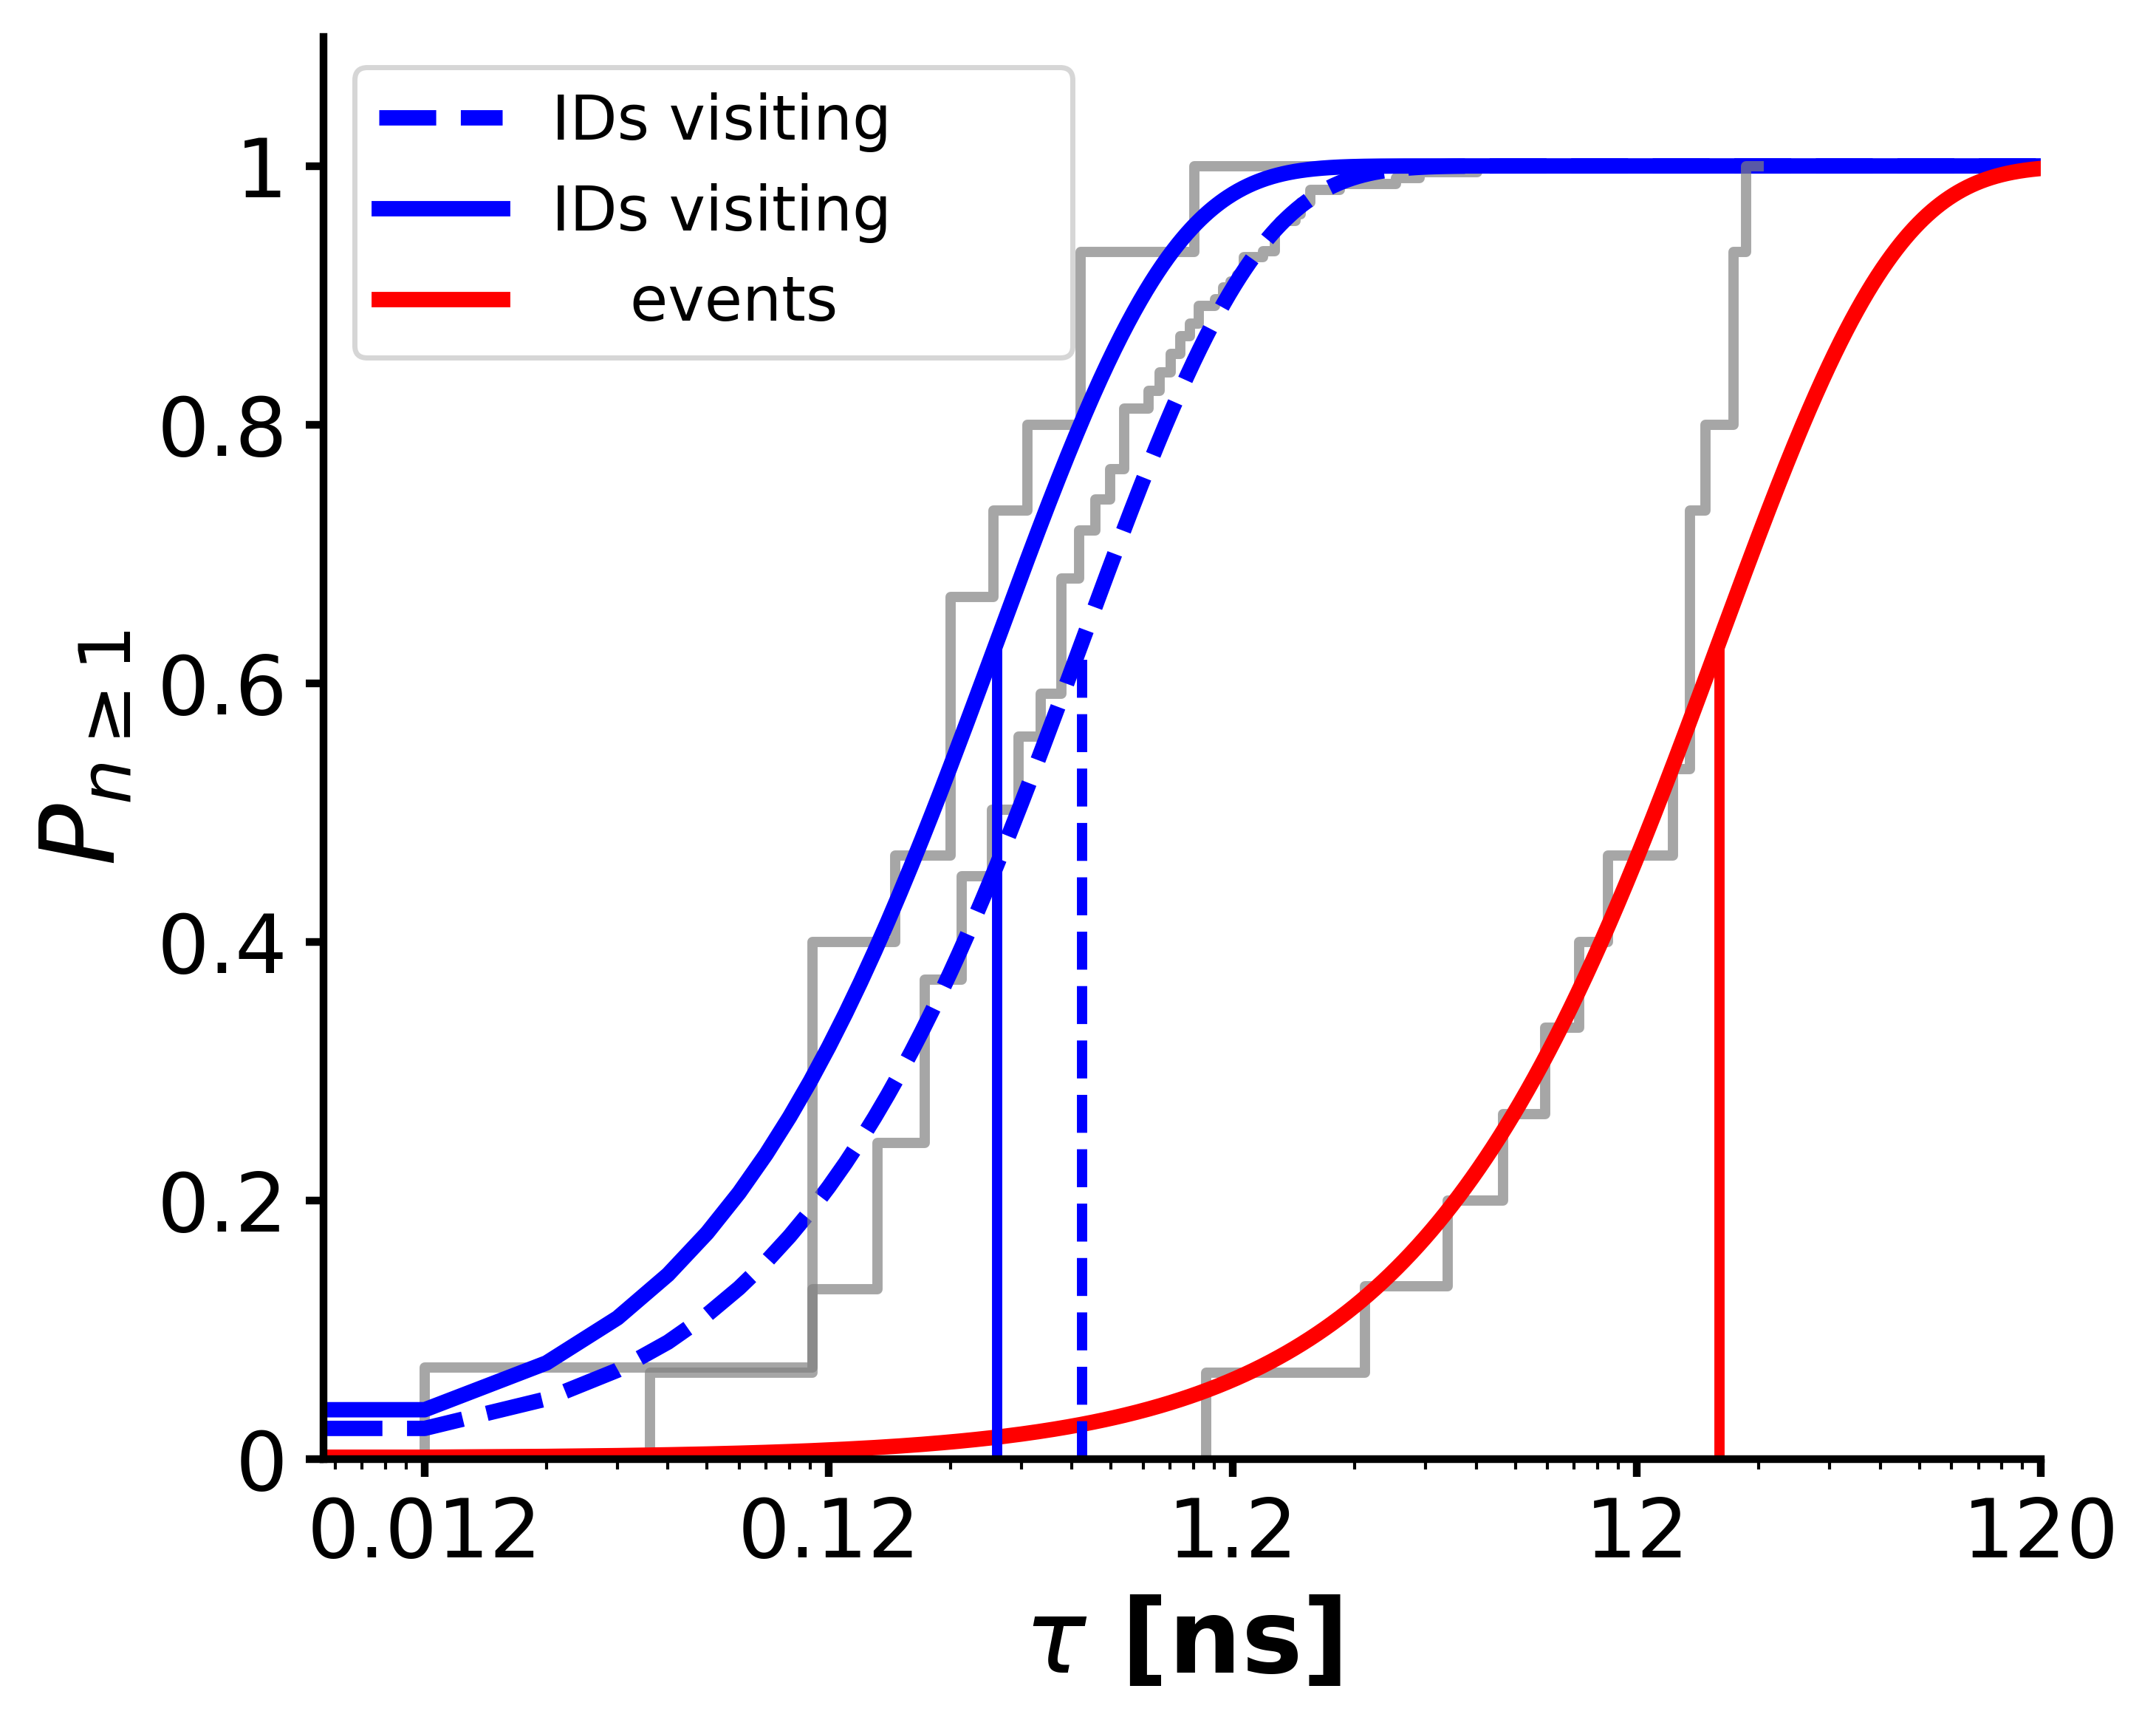

In [130]:
fig, axes = plt.subplots(
    1, figsize=(6, 5), dpi=500
)

axes.step(
        bins_countB_general[1:],
        cdfB_general,
        color="gray",
        linewidth=2,
        alpha=0.7)

axes.plot(
        x1_v3,
        fitting1_v3,
        color="blue",
        linestyle="--",
        linewidth=3,
        alpha=1,
        label='IDs visiting    ')


axes.step(
        bins_countB[1:],
        cdfB,
        color="gray",
        linewidth=2,
        alpha=0.7)

axes.plot(
        x2_v3,
        fitting2_v3,
        color="blue",
        linestyle="-",
        linewidth=3,
        alpha=1,
        label='IDs visiting        ')
        

axes.step(
        bins_countR[1:],
        cdfR,
        color="gray",
        linewidth=2,
        alpha=0.7)

axes.plot(
        x3,
        fitting3,
        color="red",
        linestyle="-",
        linewidth=3,
        alpha=1,
        label='    events')



axes.set_xlabel(r'$τ$ [ns]', weight='bold', size=20)

plt.xscale('log')
axes.set_xlim(0, 10000)

axes.vlines(fit_tau_star1/0.012, 0, y_interp1, linestyle='--', linewidth=2, color='blue')
axes.vlines(fit_tau_star2/0.012, 0, y_interp2, linestyle='-', linewidth=2, color='blue')
axes.vlines(fit_tau_star3/0.012, 0, y_interp3, linestyle='-', linewidth=2, color='red')

xticks = np.array([1, 10, 100, 1000, 10000])
axes.set_xticks(xticks)
axes.set_xticklabels([1*0.012, 10*0.012, 100*0.012, int(1000*0.012), int(10000*0.012)], fontsize=16)


# xticks = np.array([10, 100, 1000])
# axes.set_xticks(xticks)
# axes.set_xticklabels([10*12/1000, 100*12/1000, 1000*12//1000], fontsize=16)

axes.set_ylim(0, 1.1)

yticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
axes.set_yticks(yticks)
axes.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=16)

axes.set_ylabel(r'$P_{n\geq1}$', weight='bold', size=20)

for side in ['right','top']:
    axes.spines[side].set_visible(False)
for side in ['bottom','right','top','left']:
    axes.spines[side].set_linewidth(1.5)
    
    
axes.tick_params(
axis='both',          # changes apply to the x-axis
which='major',      # both major and minor ticks are affected
bottom=True,
left=True,      
labelleft=True,
labelbottom=True,
width=1.5,
labelsize=16,
)    
plt.legend(fontsize=12)
plt.savefig(XYZ_OUTDIR+'Figure/tau.png', bbox_inches='tight')

/tmp/ipykernel_19289/2651477672.py:17: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes.set_xlim(0, 150)


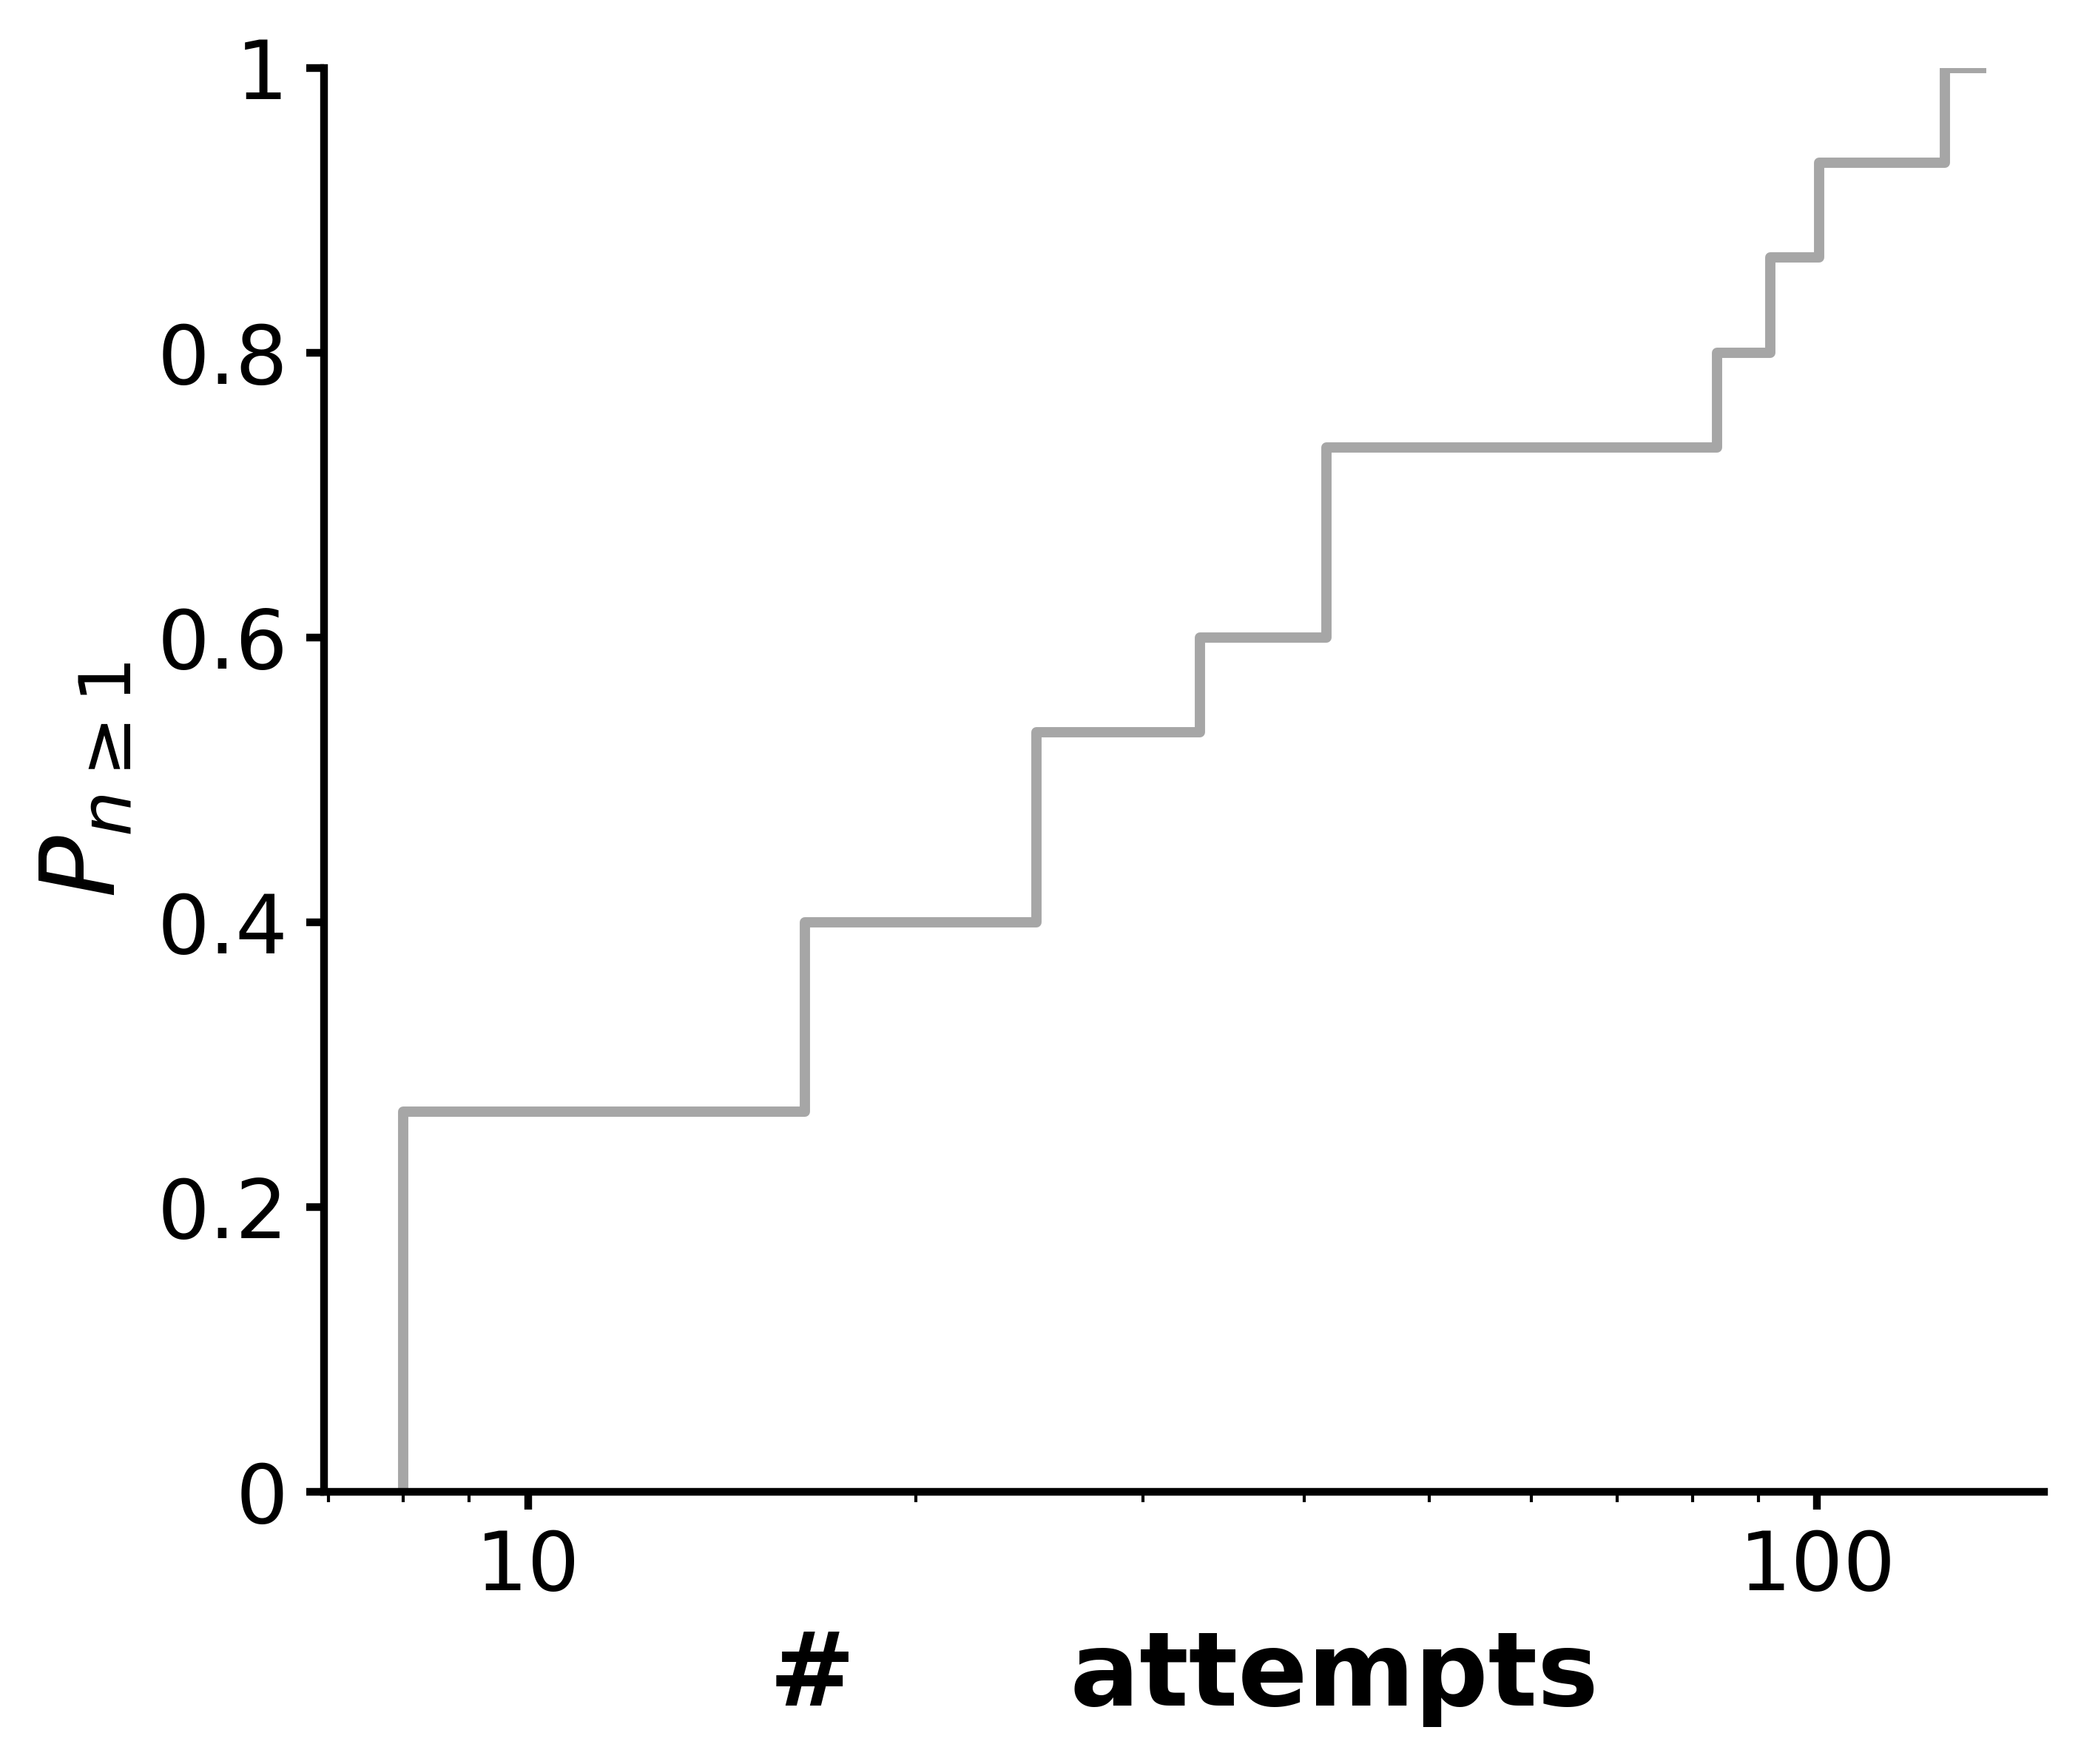

In [131]:
fig, axes = plt.subplots(
    1, figsize=(6, 5), dpi=500
)

axes.step(
        bins_countB_beforeR[1:],
        cdfB_beforeR,
        color="gray",
        linewidth=2,
        alpha=0.7)



axes.set_xlabel(r'#      attempts', weight='bold', size=20)

plt.xscale('log')
axes.set_xlim(0, 150)

xticks = np.array([10, 100])
axes.set_xticks(xticks)
axes.set_xticklabels([10, 100], fontsize=16)

axes.set_ylim(0, 1)

yticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
axes.set_yticks(yticks)
axes.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=16)

axes.set_ylabel(r'$P_{n\geq1}$', weight='bold', size=20)

for side in ['right','top']:
    axes.spines[side].set_visible(False)
for side in ['bottom','right','top','left']:
    axes.spines[side].set_linewidth(1.5)
    
    
axes.tick_params(
axis='both',          # changes apply to the x-axis
which='major',      # both major and minor ticks are affected
bottom=True,
left=True,      
labelleft=True,
labelbottom=True,
width=1.5,
labelsize=16,
)     
# plt.savefig(XYZ_OUTDIR+'Figure/blue_attempts.png', bbox_inches='tight')

In [132]:
np.savetxt(XYZ_OUTDIR+'x4.txt', bins_countB_beforeR[1:])
np.savetxt(XYZ_OUTDIR+'y4.txt', cdfB_beforeR)

In [133]:
x4_fitting = np.loadtxt(XYZ_OUTDIR+'x4_fitting.txt')
fitting4 = np.loadtxt(XYZ_OUTDIR+'fitting4.txt')

In [134]:
x4 = np.arange(0, len(fitting4))

In [135]:
bins_countB_beforeR = np.append(bins_countB_beforeR, 2000)

In [136]:
plot4_diff_to_add = 1

plot4_toappend = []
for i in range(0, plot4_diff_to_add):
    plot4_toappend.append(1) 

In [137]:
cdfB_beforeR = np.append(cdfB_beforeR, plot4_toappend)

In [138]:
parameters, covariance = curve_fit(Poissonian, x4, fitting4)
fit_tau_star4 = parameters[0]

In [139]:
fit_tau_star4

49.00511879807674

In [140]:
y_interp4 = np.interp(fit_tau_star4, x4, fitting4)

In [ ]:
fig, axes = plt.subplots(
    1, figsize=(6, 5), dpi=500
)

axes.step(
        bins_countB_beforeR[1:],
        cdfB_beforeR,
        color="gray",
        linewidth=2,
        alpha=0.7)

axes.plot(
        x4,
        fitting4,
        color="black",
        linestyle="-",
        linewidth=3,
        alpha=1)


axes.set_xlabel(r'#      attempts', weight='bold', size=20)

plt.xscale('log')
axes.set_xlim(0, 500)

xticks = np.array([1, 10, 100, 1000])
axes.set_xticks(xticks)
axes.set_xticklabels([1, 10, 100, 1000], fontsize=16)

axes.set_ylim(0, 1)

yticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
axes.set_yticks(yticks)
axes.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=16)

axes.vlines(fit_tau_star4, 0, y_interp4, linestyle='-', linewidth=2, color='black')

axes.set_ylabel(r'$P_{n\geq1}$', weight='bold', size=20)

for side in ['right','top']:
    axes.spines[side].set_visible(False)
for side in ['bottom','right','top','left']:
    axes.spines[side].set_linewidth(1.5)
    
    
axes.tick_params(
axis='both',          # changes apply to the x-axis
which='major',      # both major and minor ticks are affected
bottom=True,
left=True,      
labelleft=True,
labelbottom=True,
width=1.5,
labelsize=16,
)     
plt.savefig(XYZ_OUTDIR+'Figure/blue_attempts.png', bbox_inches='tight')